<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.stats import norm, skew
from sklearn.metrics import mean_squared_error
from math import sqrt
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import ipywidgets as widgets



color = sns.color_palette()
sns.set_style('darkgrid')

np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns',500)
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## **I. Data Cleaning**

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [4]:
house.shape

(1460, 81)

In [5]:
# Creating a function to run through the df and return columns with special characters

def find_characters(df):
    
    for v in df.select_dtypes(include=['object']).columns:
        z = df[v][~df[v].isnull()].str.findall(r'[@_!#$%^&*()<>?/\|}{~:]')
        v = [df[v].iloc[i] for i in z.index if z[i] ]
        w = pd.DataFrame(v,columns=[z.name])
        if not w.empty:
            print(w.columns,' following characters found: ' ,w.iloc[0].unique())
            
find_characters(house)

Index(['MSZoning'], dtype='object')  following characters found:  ['C (all)']
Index(['RoofMatl'], dtype='object')  following characters found:  ['Tar&Grv']


In [6]:
# Creating a function to run through the df and remove remove special characters

def characters_clean(df):
    for i in df.select_dtypes(include=['object']).columns:
        df[i] = df[i].replace(regex=[r'[@_!#$%^&*()<>?/\|}{~:]'], value = np.nan)
    
characters_clean(house)


In [7]:
# Returning the columns with NA values

house.columns[house.isnull().any()]

Index(['MSZoning', 'LotFrontage', 'Alley', 'RoofMatl', 'MasVnrType',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

**Replacing NA values with unique values that can be found in data description file or simply assumed given data contained in other columns falling under the same category.**

In [8]:
# Finding unique values

print(house.MasVnrType.unique())
print(house.Electrical.unique())

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


In [9]:
print(house.MasVnrType.isnull().sum())
print(house.Electrical.isnull().sum())

8
1


In [10]:
# Small number of nan value and impossiblity to make a resonable assumption for replacement, nan rows deleted.

house.dropna(subset=['MasVnrArea','MasVnrArea','Electrical'],inplace=True)

In [11]:
# Creating a df for the *Basement category. Replacing 'NAN' with 'NoBsm'.

bsmt = house[(house.columns.values[house.columns.str.contains('Bsm')])]

In [12]:
bsmt.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [13]:
bsmt.fillna('NoBsm',inplace=True)
 
house[(house.columns.values[house.columns.str.contains('Bsm')])] = bsmt

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [14]:
# Creating a df for the *Garage category. Replacing 'NAN' with 'NoGar'.

garage = house[(house.columns.values[house.columns.str.contains('Gar')])]
garage.fillna('NoGar',inplace=True)
garage.GarageYrBlt.replace('NoGar',0,inplace=True)

house[(house.columns.values[house.columns.str.contains('Gar')])] = garage

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
# Creating a function to take dictionary values as replacement for NA in keys (columns) 

In [16]:
repl_dict = {'Fence':'NoFnc','PoolQC':'NoPl','FireplaceQu':'NoFirpl','Alley':'NoAl',\
            'LotFrontage':0.0,'MiscFeature':'NoMisc','MSZoning':'C','RoofMatl':'TarGrv'}

In [17]:
def columns_fillna(df,dic):
    for k in dic.keys():
        val = repl_dict[k]
        df[k].fillna(val,inplace = True)
            
columns_fillna(house,repl_dict)

In [18]:
# Checking for remaining NaN values

house.columns[house.isnull().any()]


Index([], dtype='object')

In [19]:
# Converting date to int type 

def convert_col_type(df,col,t):
    df[col] = df[col].astype(t)

convert_col_type(house,['YearBuilt','YearRemodAdd','GarageYrBlt'],int)
convert_col_type(house,['MSSubClass'],str)
convert_col_type(house,['OverallQual','OverallCond'],str)

**Droping non residential property type to get a final clean dataset**

In [20]:
# Dropping non *R types

house = house[((house.MSZoning != 'C') & (house.MSZoning != 'FV'))]

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NoAl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFirpl,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPl,NoFnc,NoMisc,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NoAl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPl,NoFnc,NoMisc,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NoAl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPl,NoFnc,NoMisc,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NoAl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPl,NoFnc,NoMisc,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NoAl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPl,NoFnc,NoMisc,0,12,2008,WD,Normal,250000


In [21]:
# Cross checking 

house.MSZoning.unique()

array(['RL', 'RM', 'RH'], dtype=object)


## **II. Data classification and exploration**

In [22]:
# Classifying all renovatable features

var =['LowQualFinSF','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive',\
'PoolQC','Fence','Street','Alley','Utilities','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st',\
'Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2',\
'BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC','CentralAir','Electrical','YrSold']


In [23]:
# Classifying all fixed features

fixed = ['SalePrice','BedroomAbvGr','KitchenAbvGr','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',\
         'TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',\
         'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscFeature','MiscVal','MSSubClass','MSZoning',\
         'LotFrontage','LotArea','LotConfig','LandSlope','LotShape','LandContour','Neighborhood','Condition1',\
         'Condition2','BldgType','YearBuilt','YearRemodAdd','Foundation','BsmtCond','BsmtExposure','BsmtQual',\
         'TotalBsmtSF','1stFlrSF','2ndFlrSF','YrSold']

In [24]:
var_df = house[var]

var_df.head()

,LowQualFinSF,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,Street,Alley,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,YrSold
0,0,Gd,Typ,NoFirpl,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,2008
1,0,TA,Typ,TA,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,2007
2,0,Gd,Typ,TA,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,2008
3,0,Gd,Typ,Gd,Unf,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,2006
4,0,Gd,Typ,TA,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,2008


In [25]:
fixed_df = house[fixed]

fixed_df.head()

,SalePrice,BedroomAbvGr,KitchenAbvGr,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MSSubClass,MSZoning,LotFrontage,LotArea,LotConfig,LandSlope,LotShape,LandContour,Neighborhood,Condition1,Condition2,BldgType,YearBuilt,YearRemodAdd,Foundation,BsmtCond,BsmtExposure,BsmtQual,TotalBsmtSF,1stFlrSF,2ndFlrSF,YrSold
0,208500,3,1,1710,1,0,2,1,8,0,Attchd,2003,2,548,0,61,0,0,0,0,NoMisc,0,60,RL,65.00,8450,Inside,Gtl,Reg,Lvl,CollgCr,Norm,Norm,1Fam,2003,2003,PConc,TA,No,Gd,856,856,854,2008
1,181500,3,1,1262,0,1,2,0,6,1,Attchd,1976,2,460,298,0,0,0,0,0,NoMisc,0,20,RL,80.00,9600,FR2,Gtl,Reg,Lvl,Veenker,Feedr,Norm,1Fam,1976,1976,CBlock,TA,Gd,Gd,1262,1262,0,2007
2,223500,3,1,1786,1,0,2,1,6,1,Attchd,2001,2,608,0,42,0,0,0,0,NoMisc,0,60,RL,68.00,11250,Inside,Gtl,IR1,Lvl,CollgCr,Norm,Norm,1Fam,2001,2002,PConc,TA,Mn,Gd,920,920,866,2008
3,140000,3,1,1717,1,0,1,0,7,1,Detchd,1998,3,642,0,35,272,0,0,0,NoMisc,0,70,RL,60.00,9550,Corner,Gtl,IR1,Lvl,Crawfor,Norm,Norm,1Fam,1915,1970,BrkTil,Gd,No,TA,756,961,756,2006
4,250000,4,1,2198,1,0,2,1,9,1,Attchd,2000,3,836,192,84,0,0,0,0,NoMisc,0,60,RL,84.00,14260,FR2,Gtl,IR1,Lvl,NoRidge,Norm,Norm,1Fam,2000,2000,PConc,TA,Av,Gd,1145,1145,1053,2008


In [26]:
fixed_df.shape

(1379, 44)

In [27]:
# Looking at the correlation between numerical values
corr = fixed_df.corr()

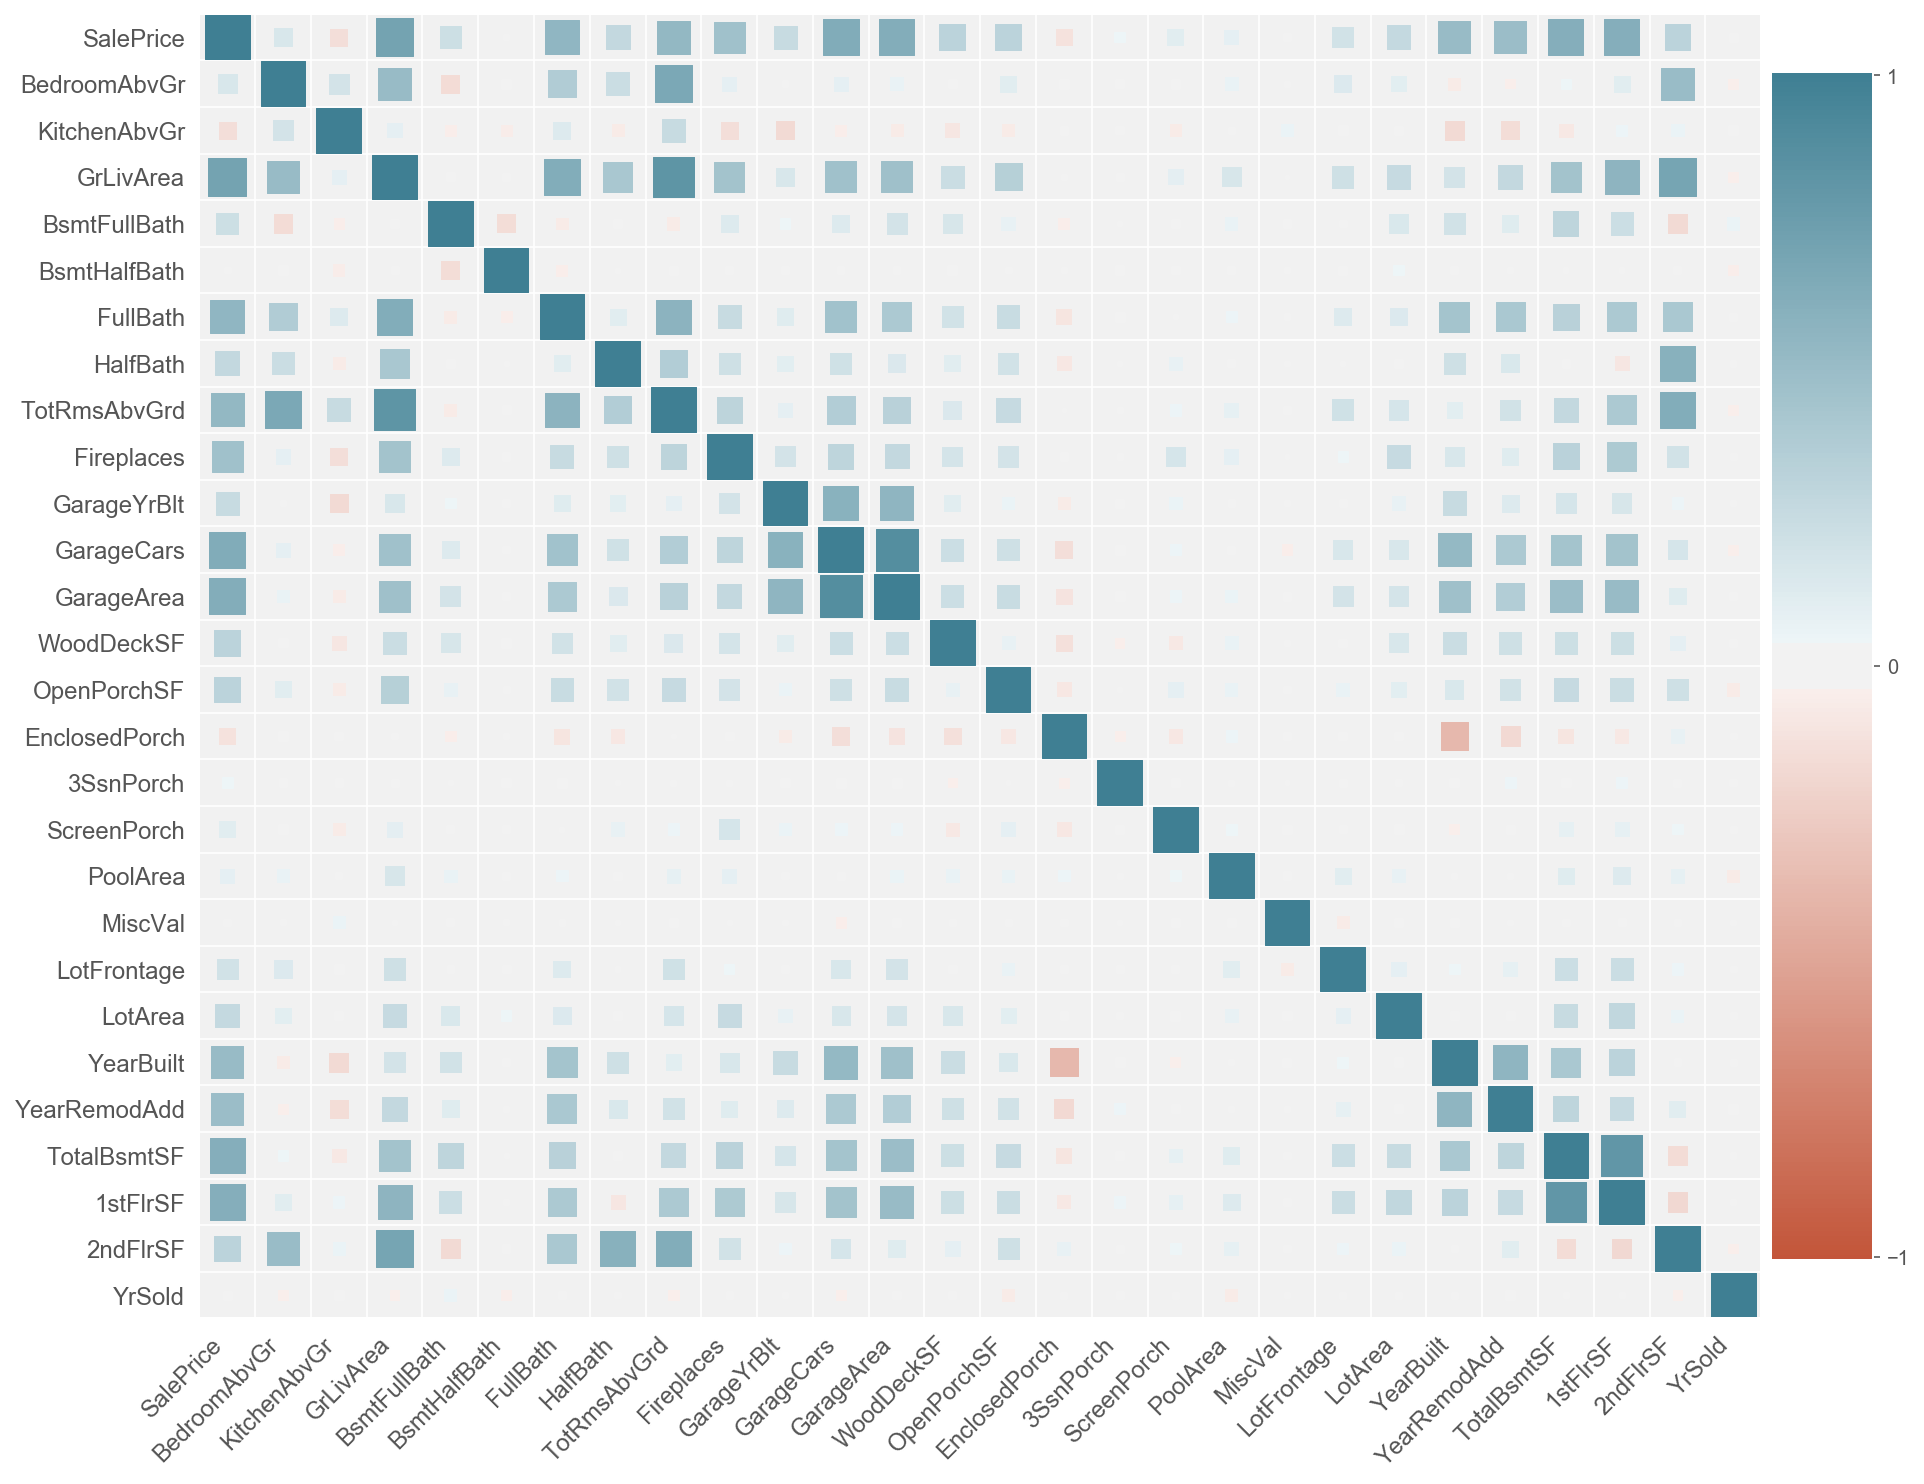

In [28]:
from ipynb.fs.full.my_functions import corrplot

plt.figure(figsize=(15, 12))
corrplot(corr)

In [29]:
# Remove variable with insignificant correlation as shown above
# Creat new heatmap showing annot and add 'interact' to get more visibility around the correlation levels. 

corr = fixed_df.drop(columns=['BsmtHalfBath','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MSSubClass']).corr()

def create_heatmap(vmin):
    fig,ax = plt.subplots(figsize=(15, 10))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    sns.heatmap(corr, mask=mask, annot=True, ax=ax,annot_kws={"size": 8},vmin=vmin,vmax=1)
    ax.set_ylim([corr.shape[1], 0])
    plt.show()

interact(create_heatmap,vmin=(-1, 1, 0.005))

interactive(children=(FloatSlider(value=0.0, description='vmin', max=1.0, min=-1.0, step=0.005), Output()), _d…

<function __main__.create_heatmap(vmin)>

**The overall surface seems to be the most positively correlated to the 
sale price.**

In [30]:
# Finding categorical variables

col = fixed_df.select_dtypes(include=['object']).columns.to_list()

In [31]:
# Creating dummy variables for the above

fixed_dum = pd.get_dummies(fixed_df, columns=col,drop_first=True)
fixed_dum.head()

,SalePrice,BedroomAbvGr,KitchenAbvGr,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,YrSold,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGar,MiscFeature_NoMisc,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtCond_Gd,BsmtCond_NoBsm,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsm,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBsm,BsmtQual_TA
0,208500,3,1,1710,1,0,2,1,8,0,2003,2,548,0,61,0,0,0,0,0,65.00,8450,2003,2003,856,856,854,2008,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,181500,3,1,1262,0,1,2,0,6,1,1976,2,460,298,0,0,0,0,0,0,80.00,9600,1976,1976,1262,1262,0,2007,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
2,223500,3,1,1786,1,0,2,1,6,1,2001,2,608,0,42,0,0,0,0,0,68.00,11250,2001,2002,920,920,866,2008,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,140000,3,1,1717,1,0,1,0,7,1,1998,3,642,0,35,272,0,0,0,0,60.00,9550,1915,1970,756,961,756,2006,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,250000,4,1,2198,1,0,2,1,9,1,2000,3,836,192,84,0,0,0,0,0,84.00,14260,2000,2000,1145,1145,1053,2008,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


##  **III. Regression pre-processing**

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import KFold

In [33]:
# Assessing the proportion of ouliers in the dataset

z = np.abs(stats.zscore(fixed_dum))

non_outliers = fixed_dum[(z < 3).all(axis=1)]

print(non_outliers.shape)
print(fixed_df.shape)

(157, 126)
(1379, 44)


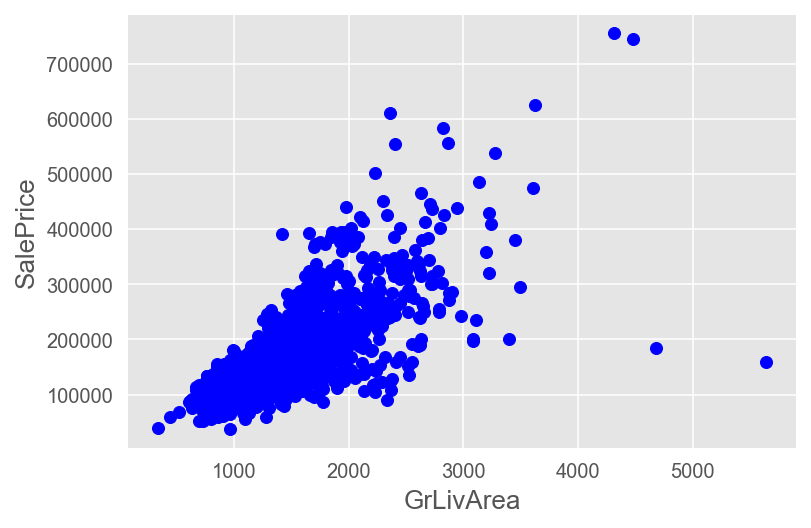

In [34]:
# Looking for significant outliers

fig, ax = plt.subplots()
ax.scatter(x = fixed_dum['GrLivArea'], y = fixed_dum['SalePrice'], c = 'blue')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

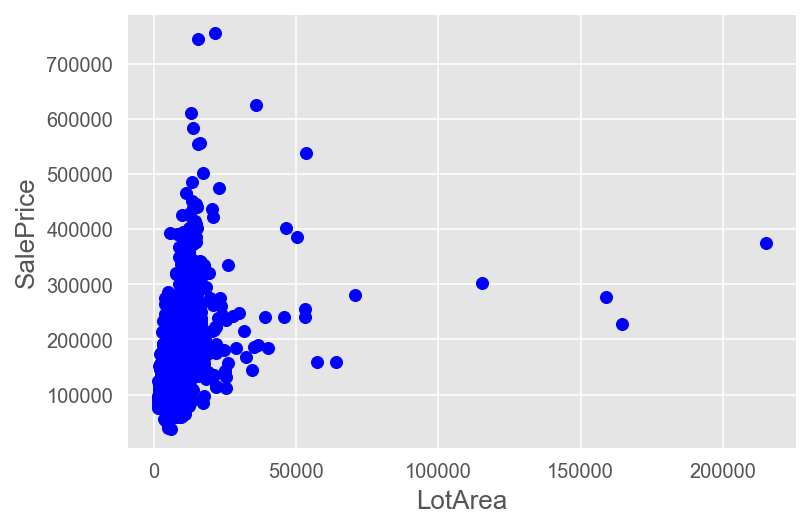

In [35]:
fig, ax = plt.subplots()
ax.scatter(x = fixed_dum['LotArea'], y = fixed_dum['SalePrice'], c = 'blue')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

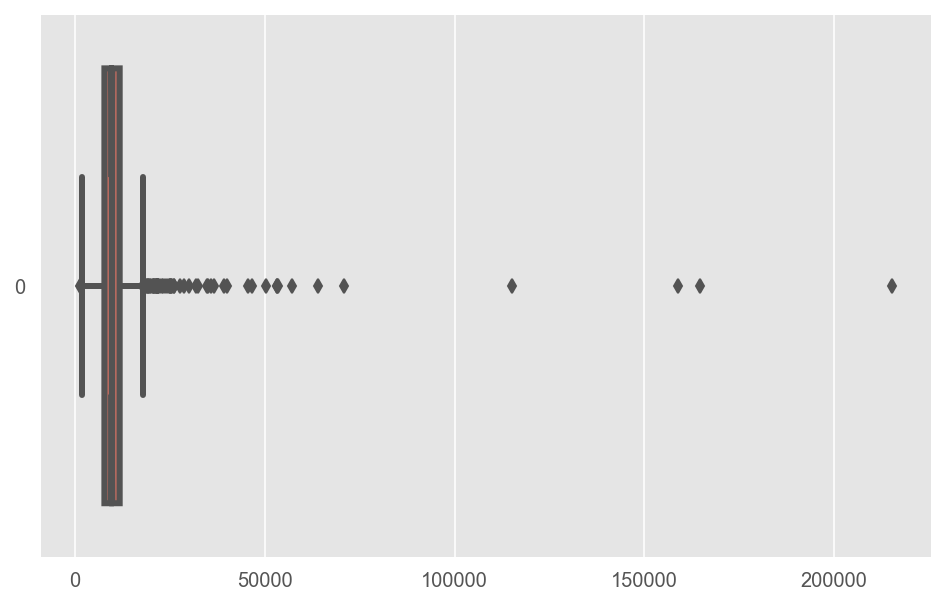

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(data=fixed_df['LotArea'], orient='h', fliersize=5,
            linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

In [37]:
# Dealing with outliers

fixed_df.LotArea.describe()

count     1379.00
mean     10692.04
std      10189.96
min       1300.00
25%       7700.00
50%       9590.00
75%      11734.00
max     215245.00
Name: LotArea, dtype: float64

In [38]:
zsLA = fixed_df.LotArea.mean() + fixed_df.LotArea.std()*3
zsLA

41261.92879289422

In [39]:
zsGL = fixed_df.GrLivArea.mean() + fixed_df.GrLivArea.std()*3
zsGL

3111.3430887418726

In [40]:
# Creating list of outliers row number

GLl = fixed_dum[(fixed_dum['GrLivArea']>zsGL)].index.to_list()
LAl = fixed_dum[(fixed_dum['LotArea']>zsLA)].index.to_list()
tl = sorted(np.unique(GLl+LAl)) #remove duplicates

In [41]:
# Dropping outliers on both fixed and renovatable df to keep the shapes align

fixed_clean = fixed_dum.drop((fixed_dum[(fixed_dum['GrLivArea']>zsGL)].index) |
                            (fixed_dum[(fixed_dum['LotArea']>zsLA)].index))


In [42]:
var_df.drop(tl,axis=0,inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
print(fixed_dum.shape)
print(fixed_clean.shape)
print(var_df.shape)

(1379, 126)
(1352, 126)
(1352, 33)


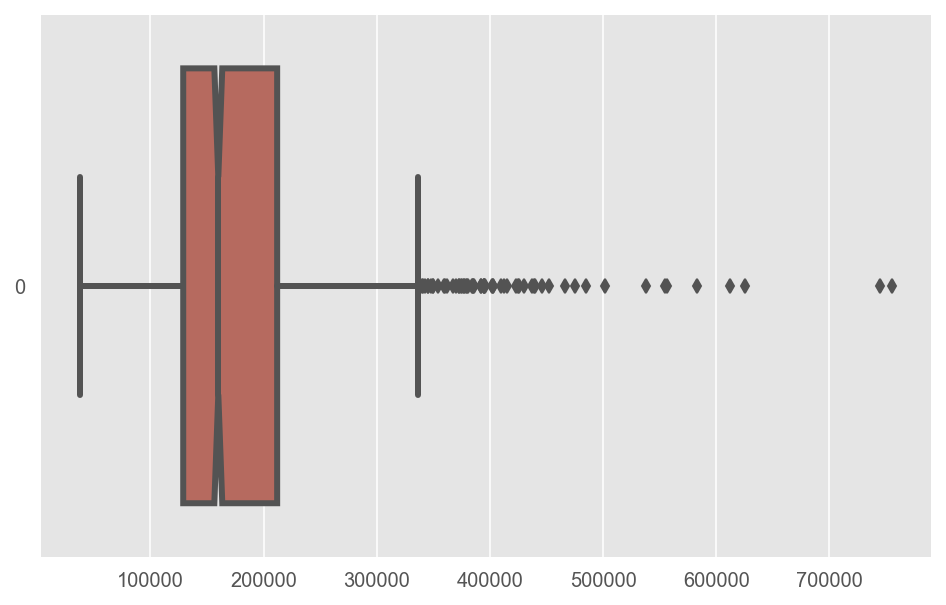

In [44]:
# Analysing the target variable

fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(data=fixed_dum['SalePrice'], orient='h', fliersize=5,
            linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()


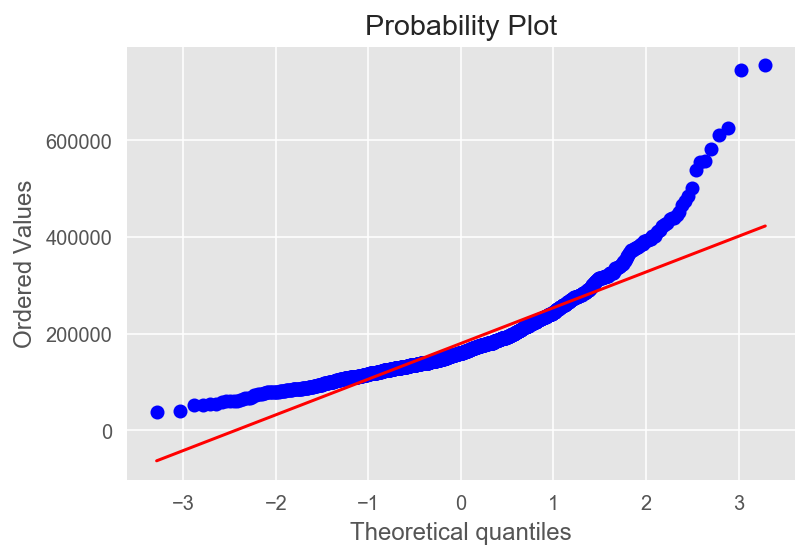

In [45]:
fig = plt.figure()
res = stats.probplot(fixed_dum['SalePrice'],plot=plt)
plt.show()

####  SalePrice contains a large number of outliers. Its distribuation is positively skewed and not  linear. Performing log tranformation didn't fix the violation.

In [46]:
# Dealing with outliers

zsSP = fixed_df.SalePrice.mean() + fixed_df.SalePrice.std()*3

In [47]:
# Creating list of outliers row number

SPl = fixed_clean[(fixed_clean['SalePrice']>zsSP)].index.to_list()

In [48]:
# Dropping outliers on both df

fixed_clean = fixed_clean.drop((fixed_clean[(fixed_clean['SalePrice']>zsSP)].index))

In [49]:
var_df.drop(SPl,axis=0,inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [50]:
print(fixed_clean.shape)
print(var_df.shape)

(1338, 126)
(1338, 33)


In [51]:
# Define predictor matrix and target variable

y = fixed_clean['SalePrice']

X = fixed_clean.drop('SalePrice',axis=1)


In [52]:
X.shape

(1338, 125)

In [129]:
# get train-test split

X_train = fixed_clean[(fixed_clean['YrSold'] < 2010)]
y_train = X_train.pop('SalePrice')
X_test = fixed_clean[(fixed_clean['YrSold'] == 2010)]
y_test = X_test.pop('SalePrice')

print(X_train.YrSold.unique())
print(X_test.YrSold.unique())


[2008 2007 2006 2009]
[2010]


In [54]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1180, 125)
(1180,)
(158, 125)
(158,)


In [55]:
# standardize the data

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)

## **IV. Modelling**

### a. Testing models

In [56]:
def alpha_scores(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, alpha_values=np.logspace(-10, 10, 21)):
    scores = []
    for alpha in alpha_values:
        scores.append(model_fitter(
            model(alpha), X_train, y_train, X_test, y_test))
    return scores


In [57]:
def model_fitter(model, X_train, y_train, X_test, y_test,cv=KFold(n_splits=3,shuffle=False,random_state = 1)):
    model.fit(X_train, y_train)
    cv_train_score = (np.mean(cross_val_score(model, X_train, y_train, cv=cv)))
    cv_test_score = (np.mean(cross_val_score(model, X_test, y_test, cv=cv)))
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return cv_train_score, cv_test_score, training_score, test_score

In [58]:
def graph_coef(model):
    coef = pd.DataFrame(model.coef_.T, index=X_train.columns,columns=['coefficients'])
    imp_coef = pd.concat([coef.sort_values('coefficients').head(10),coef.sort_values('coefficients').tail(10)])
    fig = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Coefficients in the model")
    return fig

In [59]:
def plt_predictions(model):
    predict = cross_val_predict(model, X_train, y_train, cv=KFold(n_splits=3,shuffle=False,random_state = 1))
    predict_test = cross_val_predict(model, X_test, y_test, cv=KFold(n_splits=3,shuffle=False,random_state = 1))

    plt.figure(figsize=(10, 8))
    y_range = [y_train.min(), y_train.max()]
    plt.plot(y_range,y_range, lw=2, c='k')
    plt.scatter(predict, y_train, c='b', alpha=0.5,label = 'train')
    plt.scatter(predict_test, y_test, c='r', alpha=0.5,label='test')
    plt.xlabel('predicted y')
    plt.ylabel('true y')
    plt.legend()

### ~ Linear Regression

In [60]:
model = LinearRegression()
model_fitter(model, X_train, y_train, X_test, y_test)

(-8.197005010803562e+21,
 -0.908379837079807,
 0.9055776410894857,
 0.872917680048382)

(8.0, 10.0)

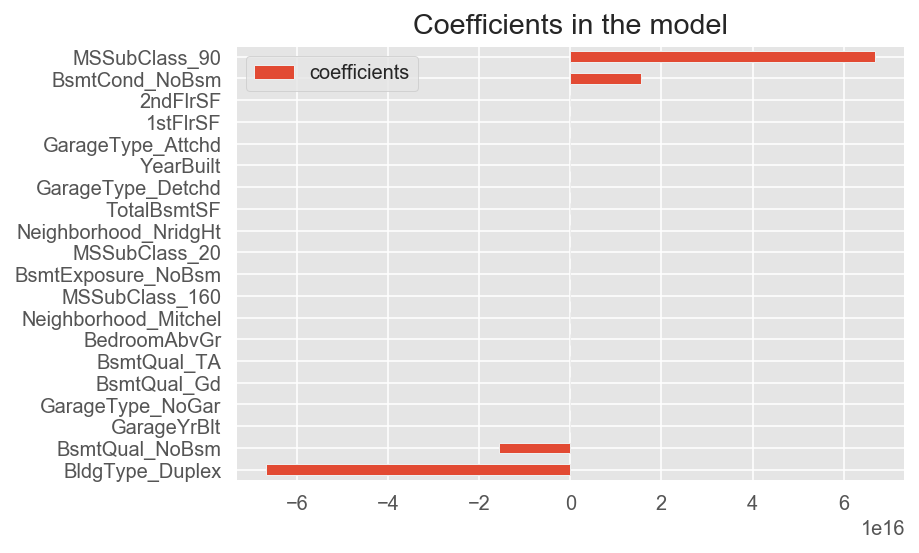

In [61]:
graph_coef(model)

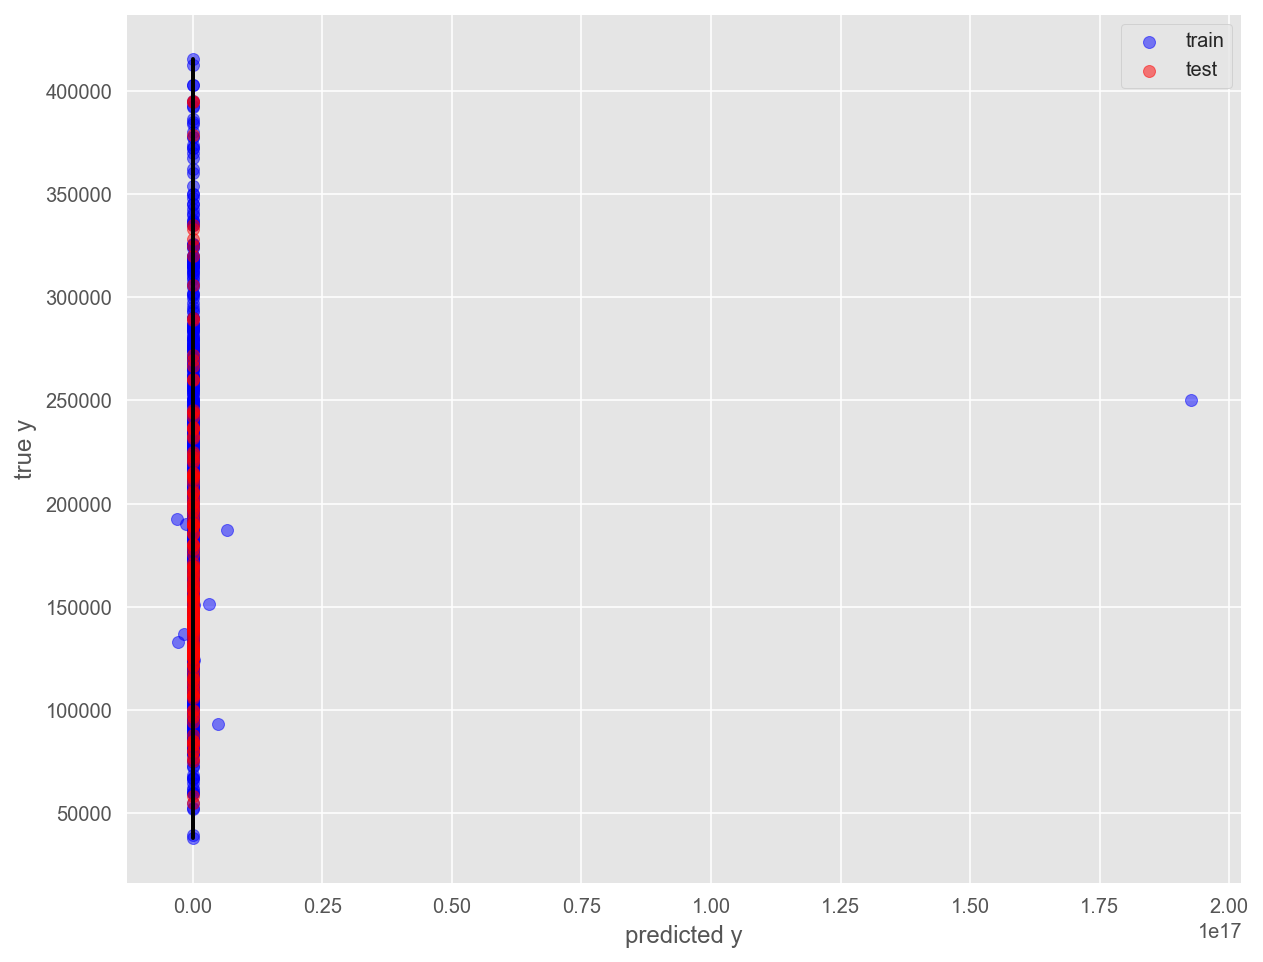

In [62]:
plt_predictions(model)

### ~ Ridge

In [63]:
from sklearn.linear_model import Ridge,RidgeCV

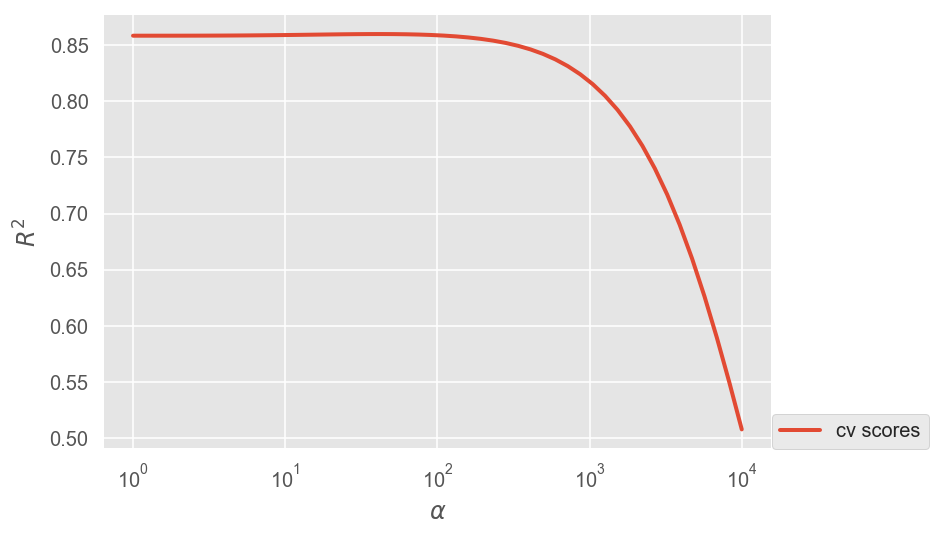

In [64]:
# Visualising alpha relationship to R2 to define a logspace

alpha_values = np.logspace(0, 4, 50)
scores = alpha_scores(Ridge, alpha_values=alpha_values)

plt.plot(alpha_values, [score[0] for score in scores], lw=2, label='cv scores')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$')
plt.legend(loc=[1, 0])
plt.show()

In [65]:
# create a RidgeCV model instance
model = RidgeCV(alphas=np.logspace(0,4,50), cv=KFold(n_splits=3,shuffle=False,random_state = 1))
# fit the model
model.fit(X_train, y_train)

# get the best alpha
print('Best alpha:', model.alpha_)

Best alpha: 42.91934260128776


In [66]:
# create a Ridge model instance

In [67]:
model = Ridge(alpha = 42.9)
model_fitter(model, X_train, y_train, X_test, y_test)

(0.8598826250651498, 0.8097074766415434, 0.9031831461169371, 0.873885146892729)

(8.0, 10.0)

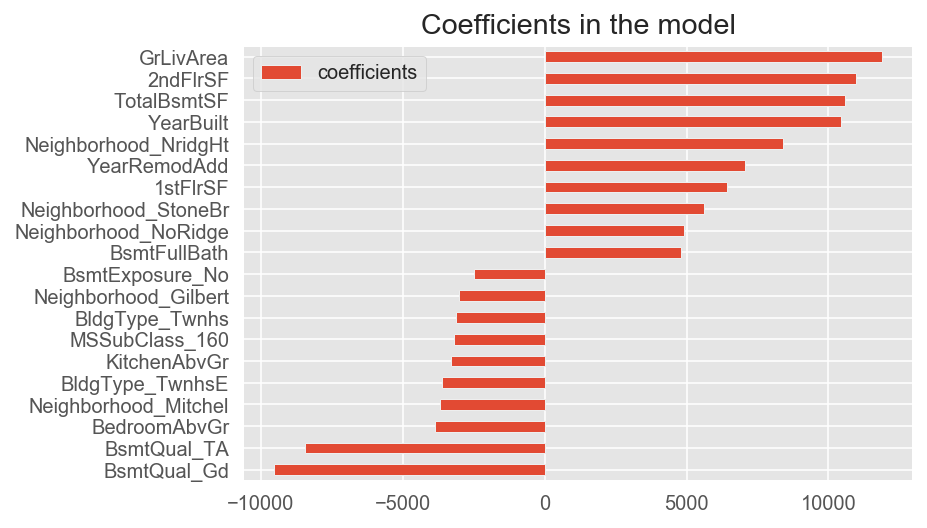

In [68]:
graph_coef(model)

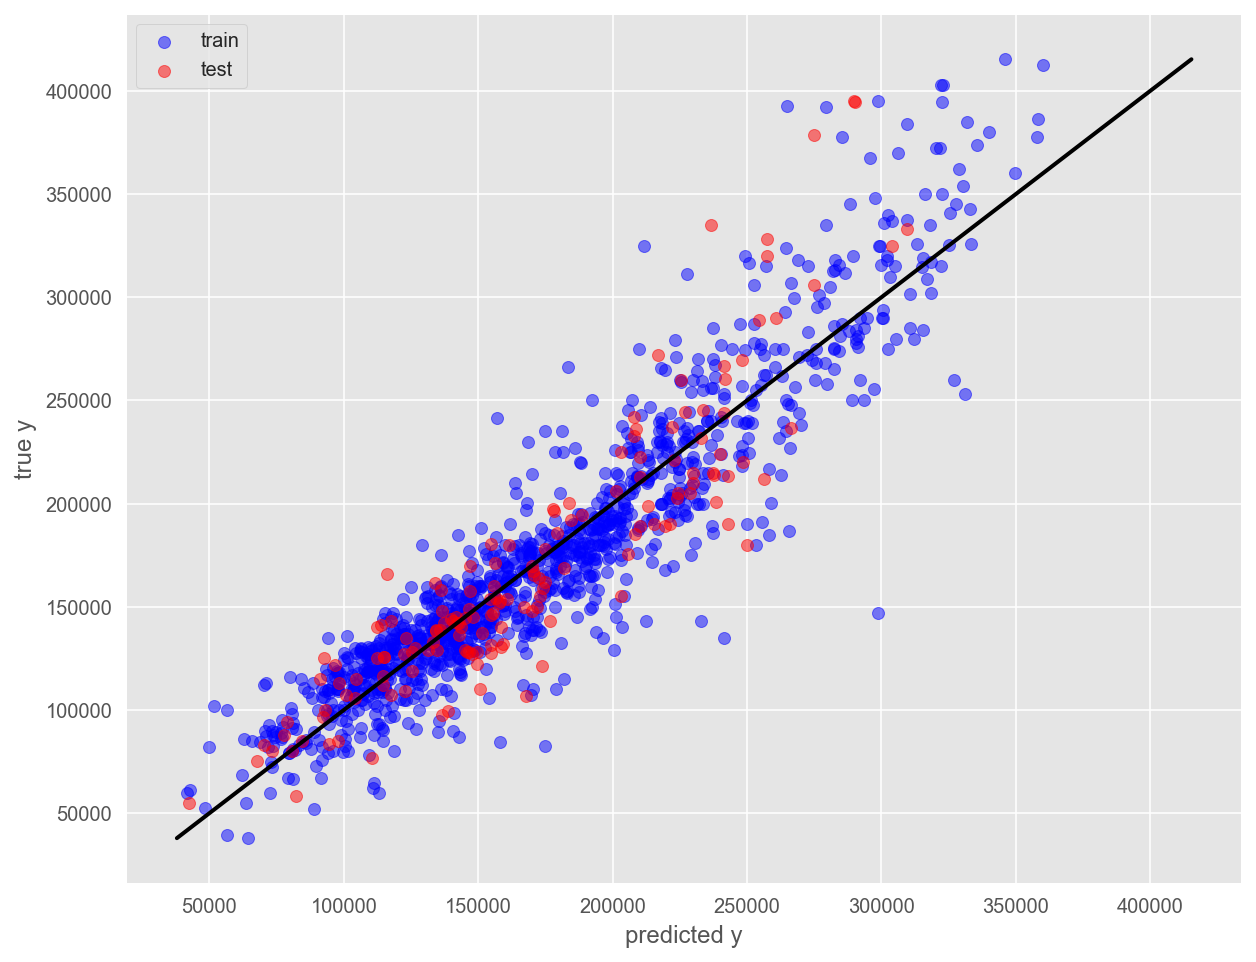

In [69]:
plt_predictions(model)

## ~ Lasso

In [70]:
from sklearn.linear_model import Lasso, LassoCV

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203111835470.4132, tolerance: 511041588.3237116
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116601230602.4693, tolerance: 323434631.10686517
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133810585683.8925, tolerance: 339047916.8094646
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11379650143

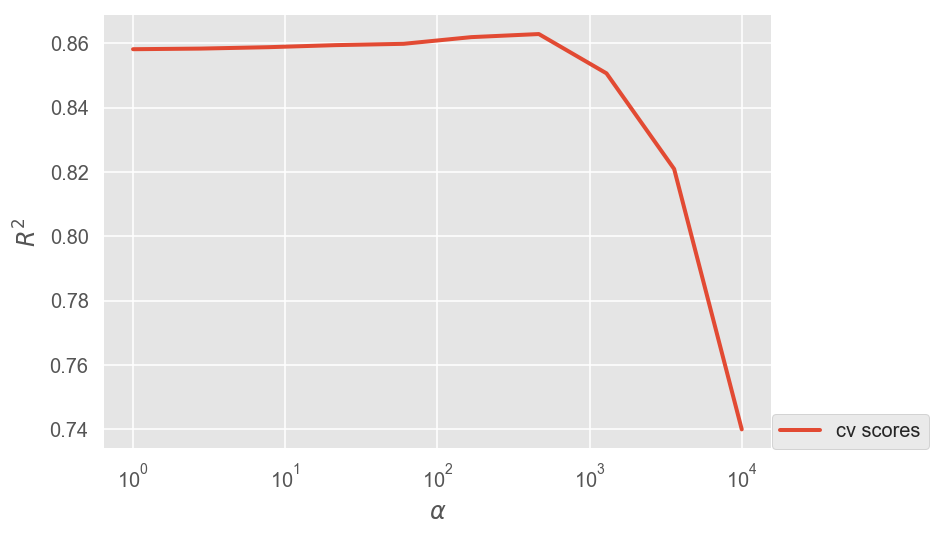

In [71]:
alpha_values = np.logspace(0, 4, 10)
scores = alpha_scores(Lasso, alpha_values=alpha_values)

plt.plot(alpha_values, [score[0] for score in scores], lw=2, label='cv scores')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$')
plt.legend(loc=[1, 0])

plt.show()

In [72]:
# create a LassoCV model instance
model = LassoCV(alphas=np.logspace(0, 4, 10), cv=KFold(n_splits=3,shuffle=False,random_state = 1),max_iter=10000)
# fit the model
model.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model.alpha_)


Best alpha: 464.15888336127773


In [73]:
model = Lasso(alpha=464)
model_fitter(model, X_train, y_train, X_test, y_test)

(0.86286196377681, 0.7965981092922697, 0.8971618948300718, 0.8760528504725414)

(8.0, 10.0)

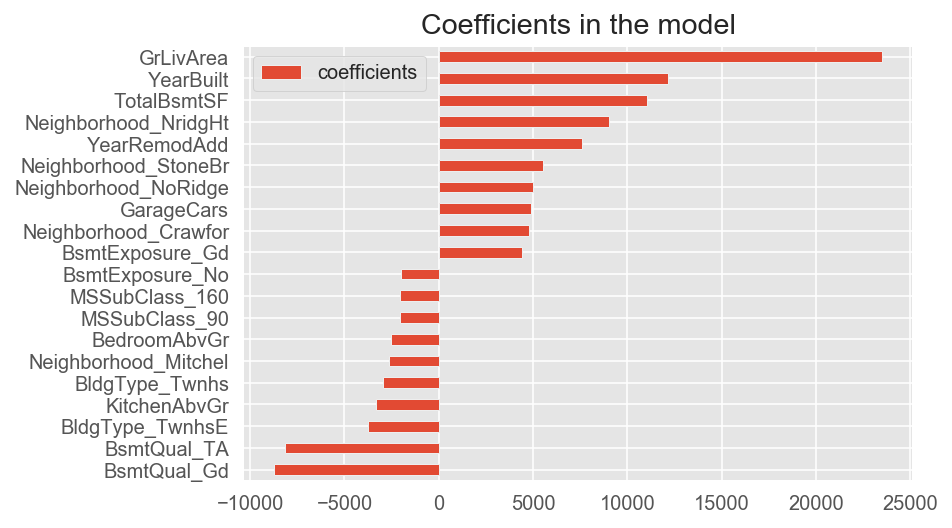

In [74]:
graph_coef(model)

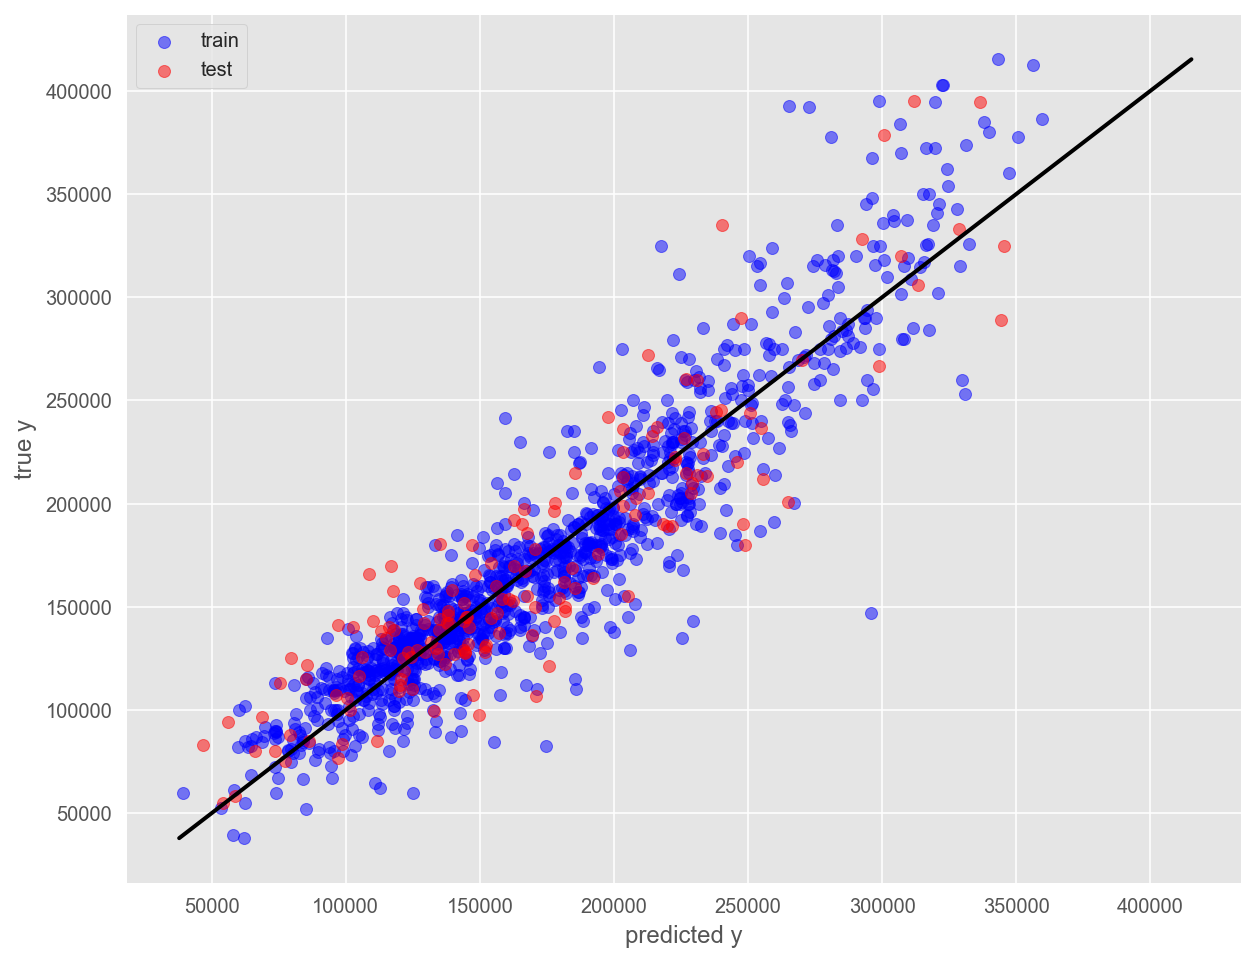

In [75]:
plt_predictions(model)

## ~ ElasticNet

In [76]:
from sklearn.linear_model import ElasticNet

In [77]:
model = ElasticNet(alpha=0.8, l1_ratio=0.6)
model_fitter(model, X_train, y_train, X_test, y_test)

(0.8532173388043164,
 0.8089971550190409,
 0.8865107053937532,
 0.8611702740168211)

(8.0, 10.0)

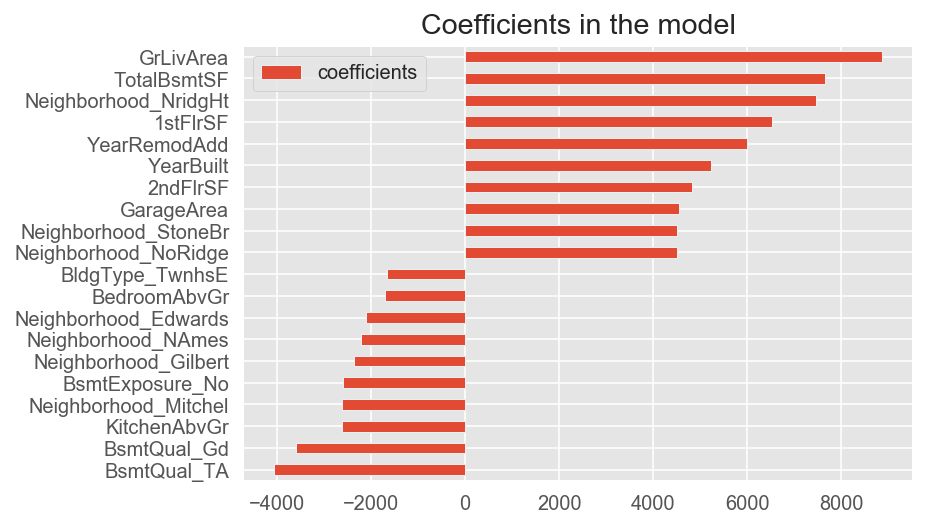

In [78]:
graph_coef(model)

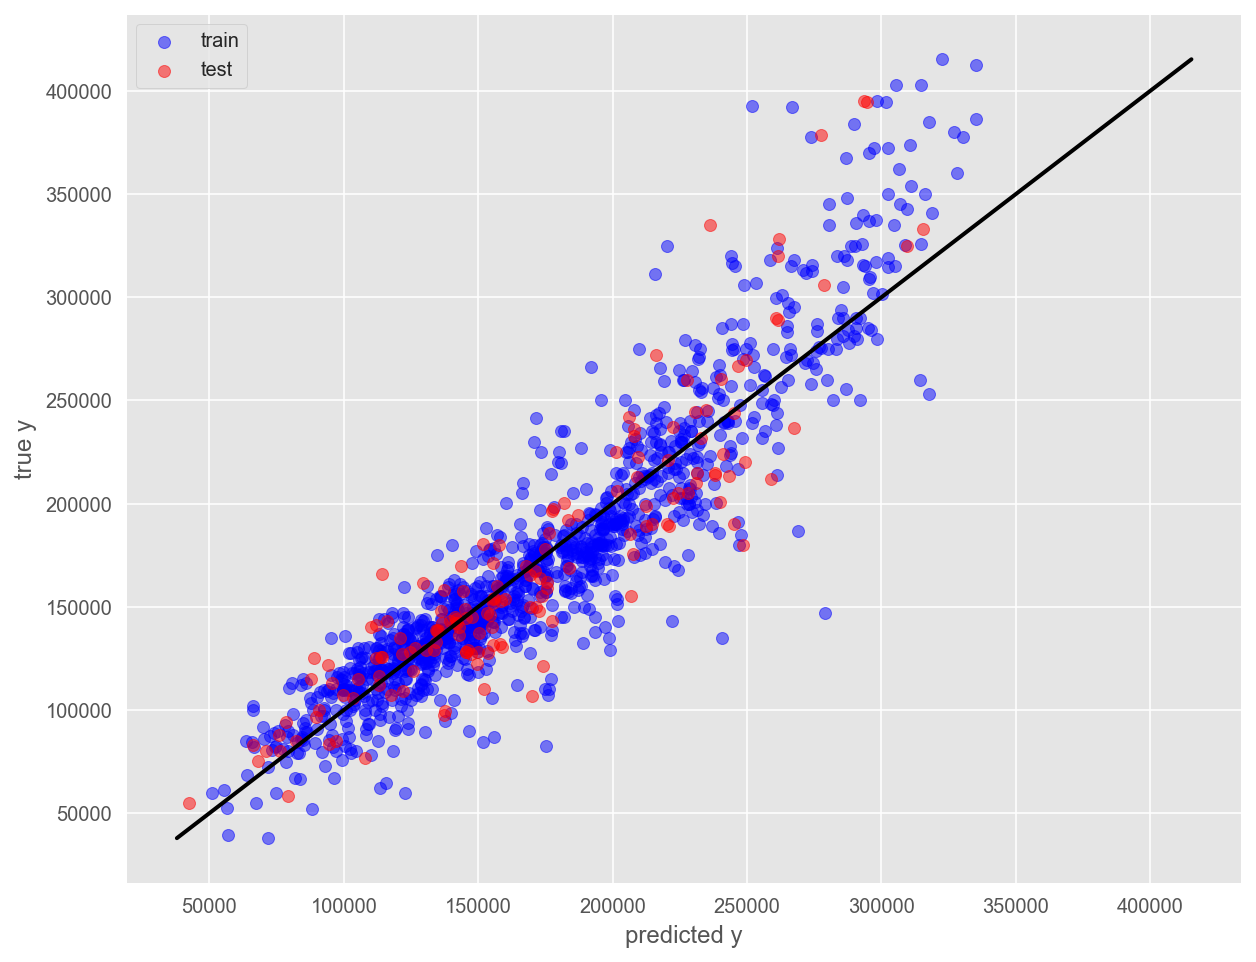

In [79]:
plt_predictions(model)

The elasticnet model has the highest scores. From the prediction plot we can see that overall the results are pretty accurate, with some outliers. 

### b. Residuals 

In [80]:
# Getting the residuals of the elasticNet regression 

In [81]:
yhat = model.predict(X_test)

In [82]:
z = (y_test - yhat)

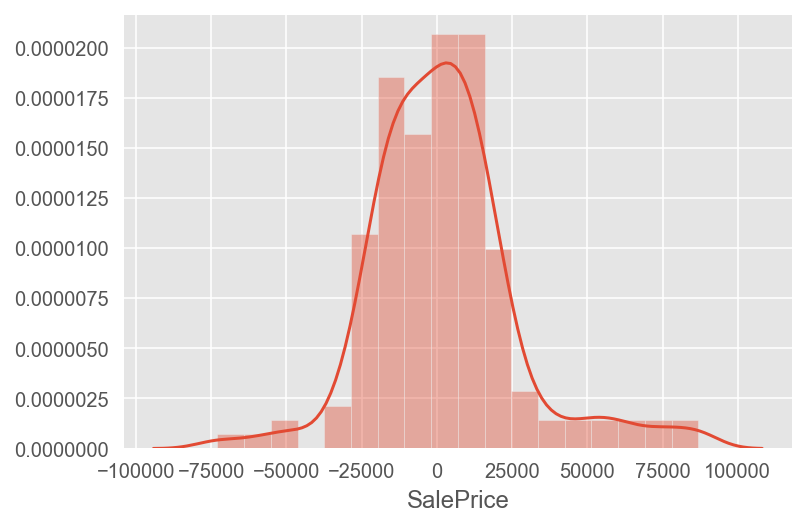

In [83]:
# Plotting residuals

sns.distplot((y_test - yhat))

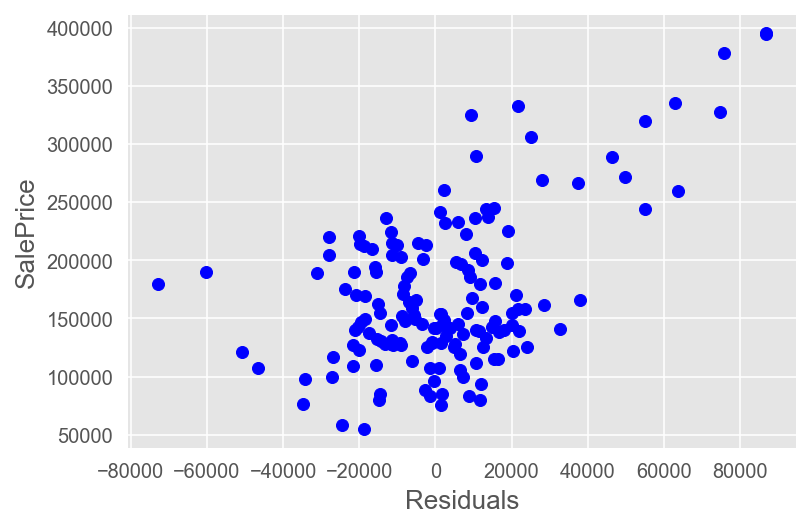

In [84]:
fig, ax = plt.subplots()
ax.scatter(x = z, y = y_test, c = 'blue')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Residuals', fontsize=13)
plt.show()

In [85]:
# Testing normality of residuals

k2, p = stats.normaltest(z)
alpha = 0.05

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: z comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 9.66272e-07
The null hypothesis can be rejected


#### The residuals are not normally distributed but we will accept the violation. The most significant outliers have already been removed.

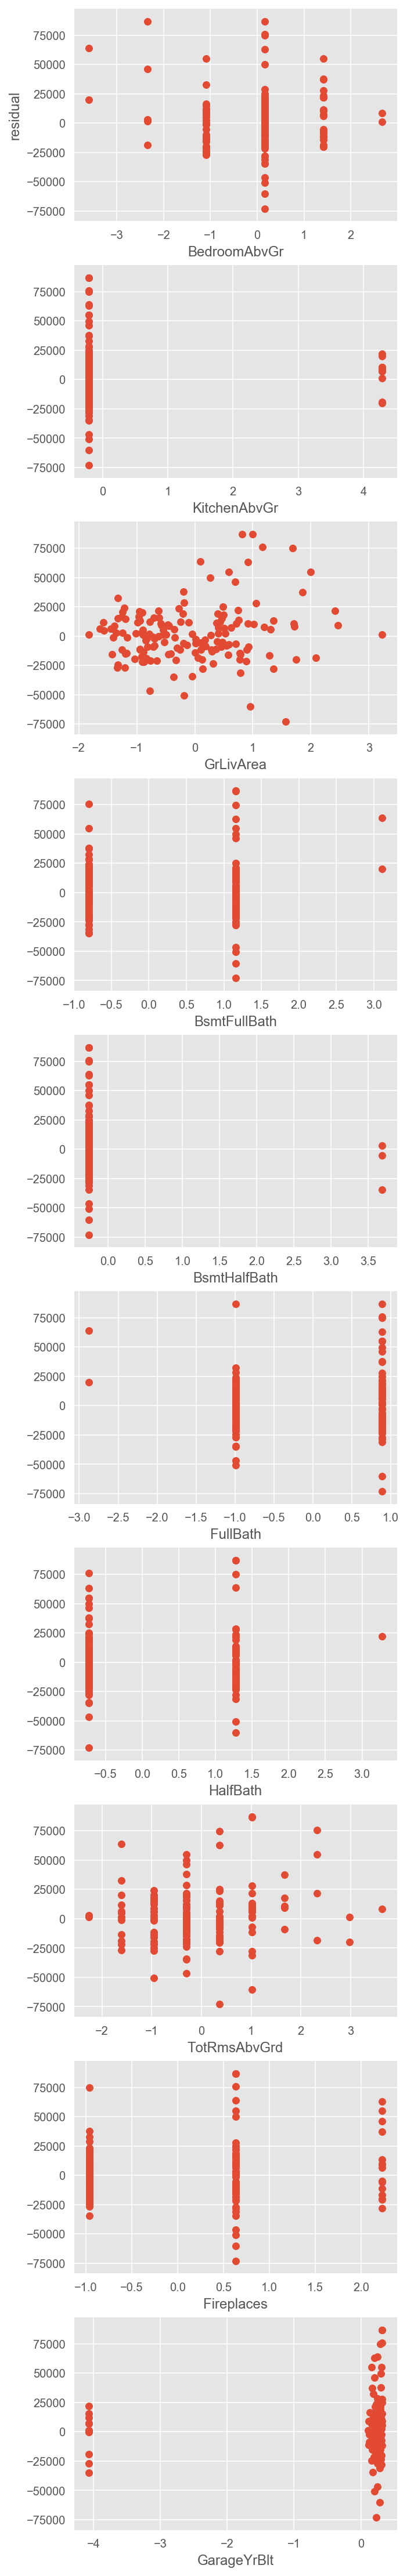

In [86]:
# Plotting correlation between variables and residuals

fig, ax = plt.subplots(nrows=10 ,figsize=(5, 40), sharey=True)
for i, col in enumerate(X.columns[:10]):
    ax[i].scatter(X_test[col], (z))
    ax[i].set_xlabel(col)
ax[0].set_ylabel('residual')
plt.show()

#### No noticeable correlation with the selected predictors.

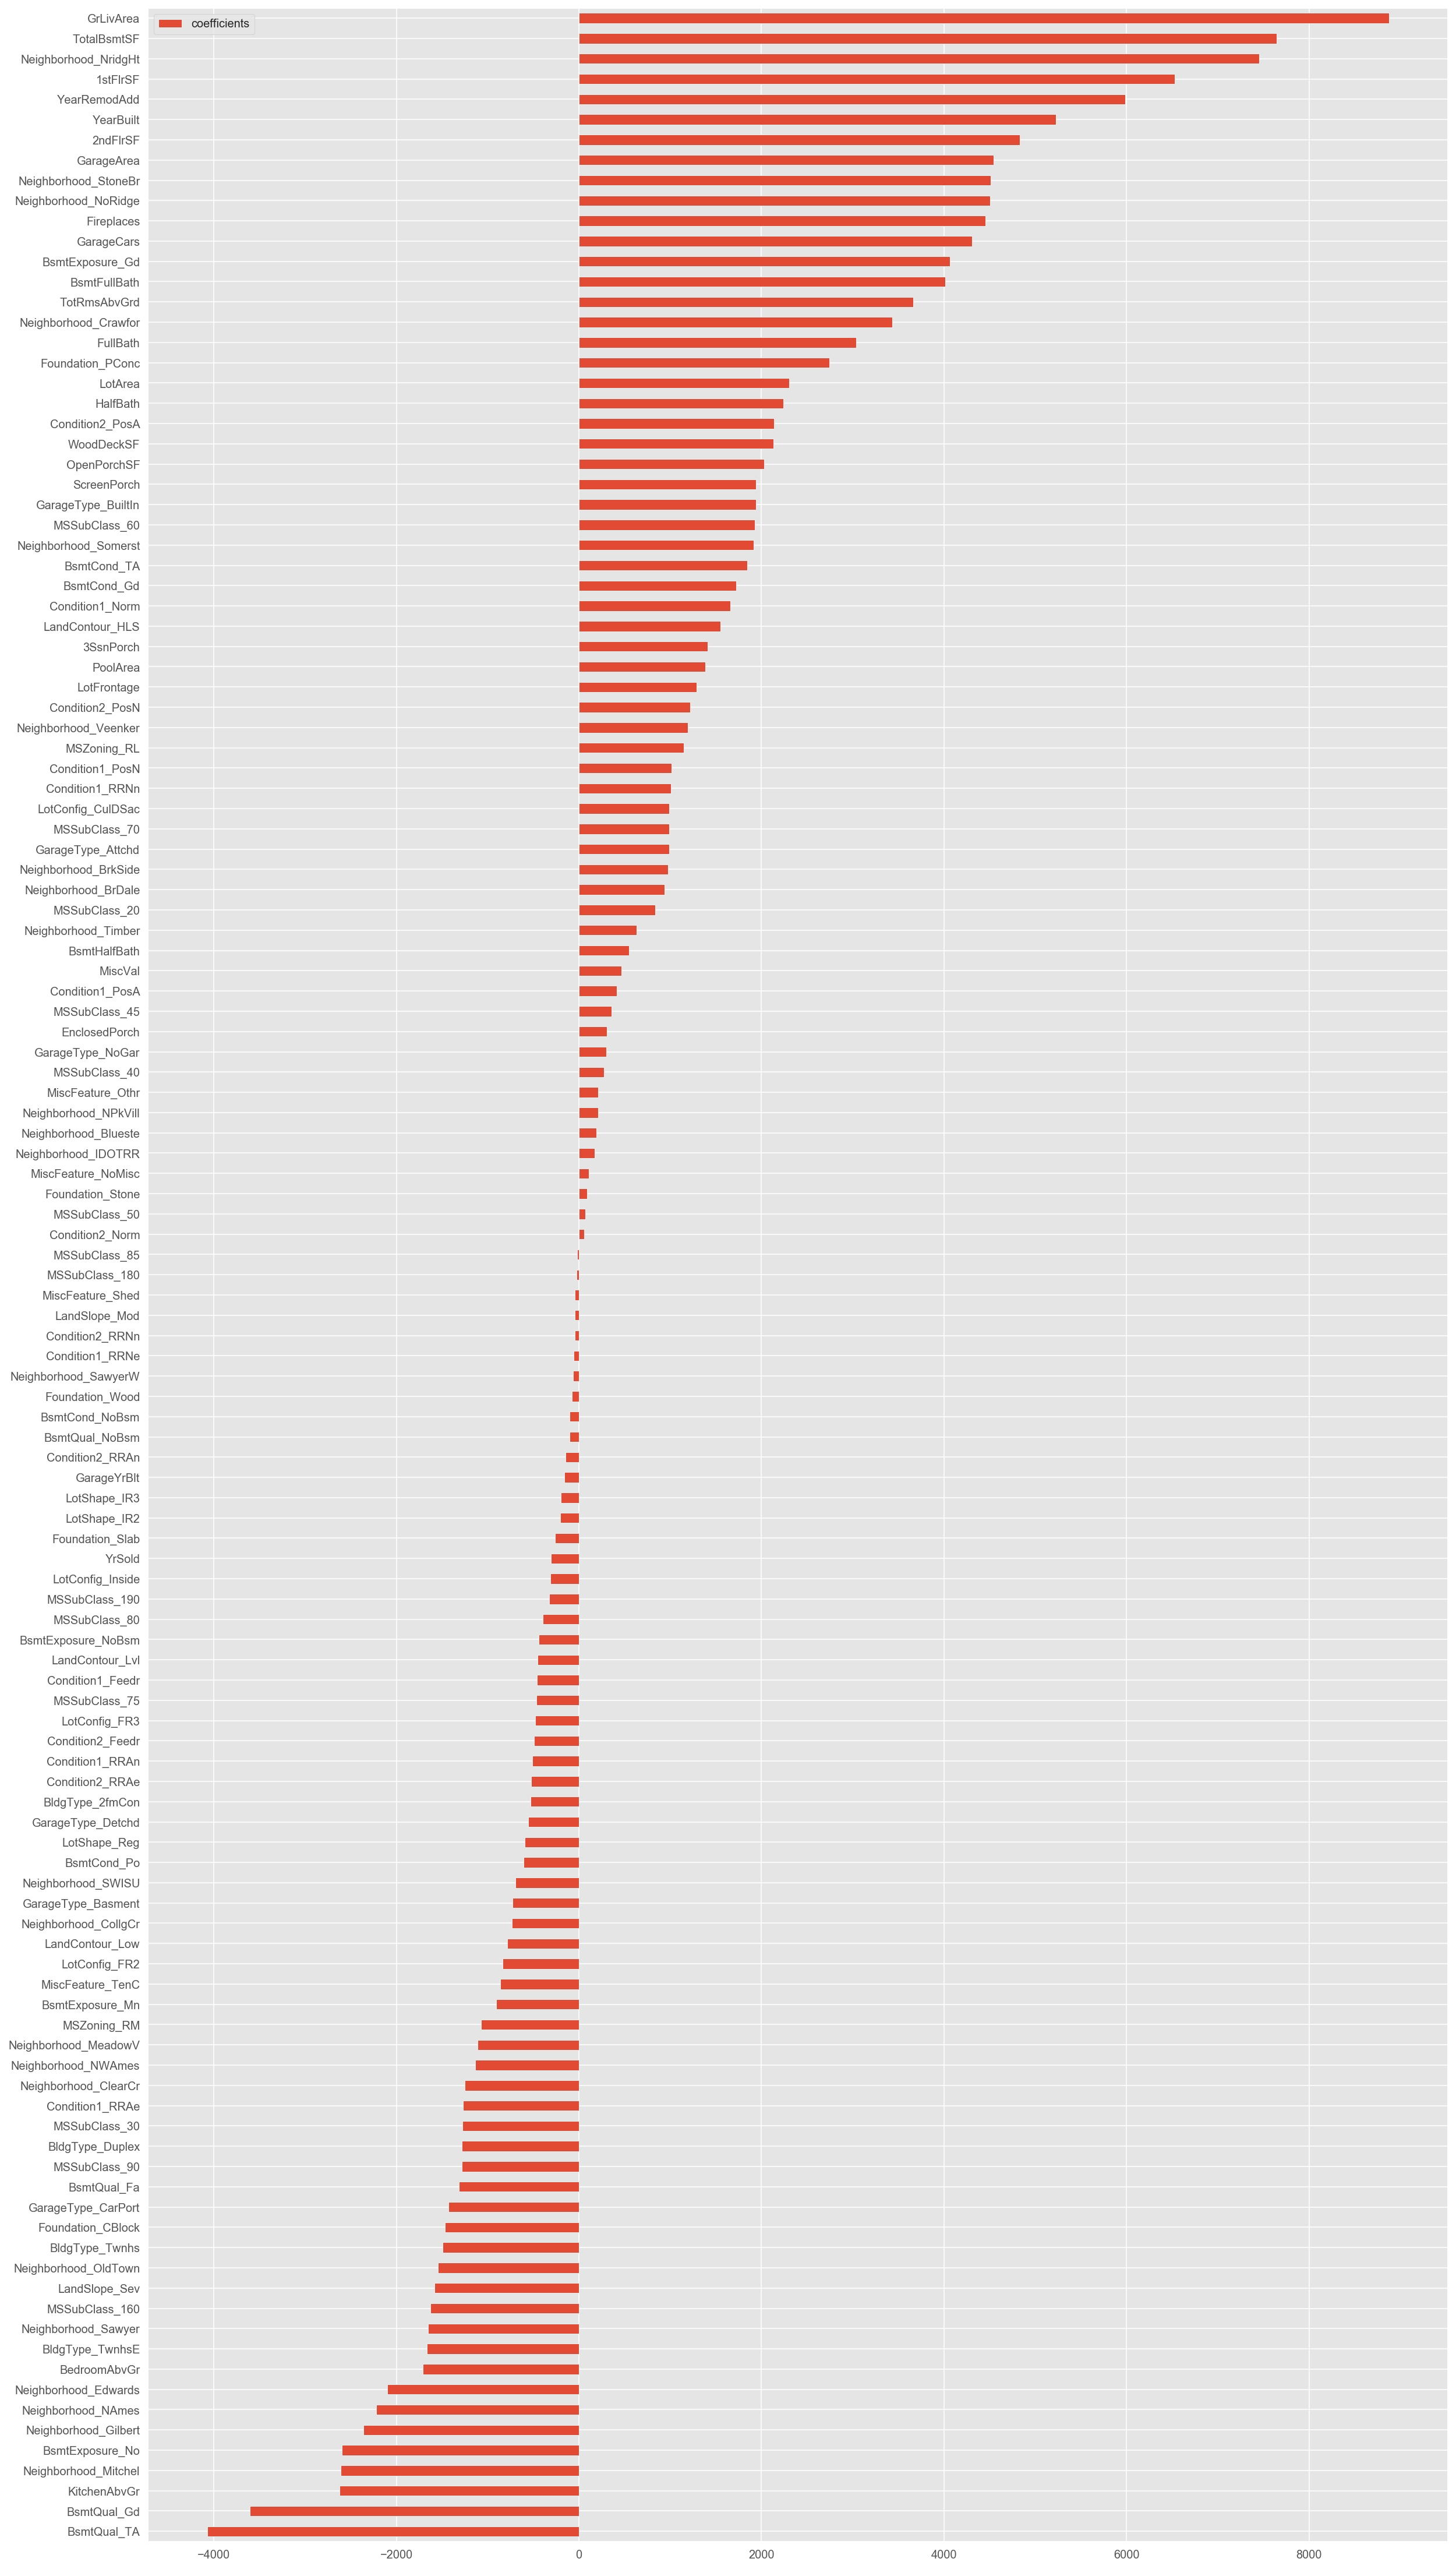

In [87]:
# General overview of the coefficients 

coef = pd.DataFrame(model.coef_.T, index=X_train.columns,columns=['coefficients'])

coef.sort_values('coefficients', ascending=True,inplace=True)

coef.plot(kind = "barh",figsize=(20, 40))


In [88]:
model.intercept_

173393.59152542375

Overall, the main drivers are the neighborhood and the total surface. Any basement without exposure and below 100 inch are negatively correlated to the price.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## I. Residuals 

In [130]:
# Get residuals of X for fixed features

Xstd = scaler.transform(X)

model = ElasticNet(alpha=0.8, l1_ratio=0.6 )
model.fit(Xstd, y)

yhat = model.predict(Xstd)


In [90]:
X.shape

(1338, 125)

In [91]:
# Calculating residuals

z = (y-yhat)

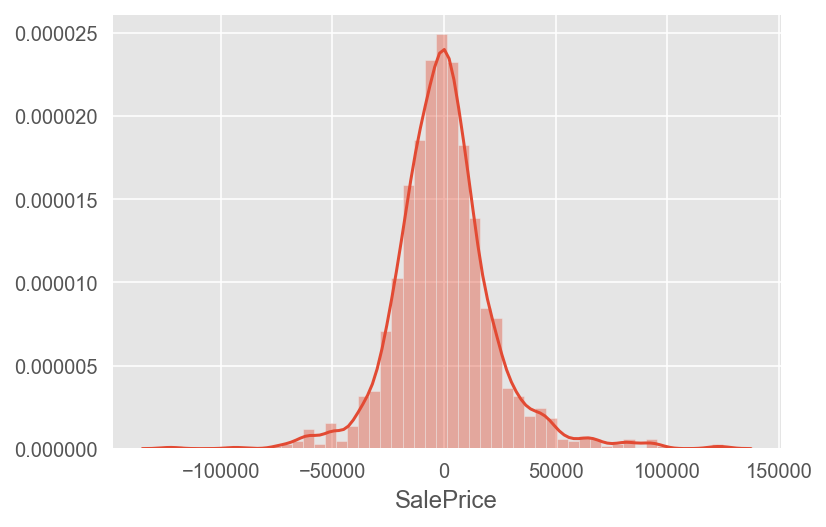

In [92]:
# Plotting residuals of full dataset (X)

sns.distplot((y - yhat))

In [93]:
# Testing for normality 

k2, p = stats.normaltest(z)
alpha = 0.05

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 4.42069e-43
The null hypothesis can be rejected


#### As expected, the residuals are not nornally distributed. The fixed variables were highly skewed.

### II. Model Preprocessing 

In [94]:
# Preparing renovatable df from previously defined var_df

In [95]:
var_df.insert(1,'residuals',z)

In [96]:
var_df.head()

,LowQualFinSF,residuals,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,Street,Alley,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,YrSold
0,0,4538.51,Gd,Typ,NoFirpl,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,2008
1,0,-13413.86,TA,Typ,TA,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,2007
2,0,8891.02,Gd,Typ,TA,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,2008
3,0,-58505.59,Gd,Typ,Gd,Unf,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,2006
4,0,-36659.01,Gd,Typ,TA,RFn,TA,TA,Y,NoPl,NoFnc,Pave,NoAl,AllPub,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,2008


In [97]:
col = var_df.select_dtypes(include=['object']).columns.to_list()

In [98]:
# Creating dummy variables for the above

var_dum = pd.get_dummies(var_df, columns=col,drop_first=True)
var_dum.head()

,LowQualFinSF,residuals,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,YrSold,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirpl,FireplaceQu_Po,FireplaceQu_TA,GarageFinish_NoGar,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGar,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGar,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,PoolQC_NoPl,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFnc,Street_Pave,Alley_NoAl,Alley_Pave,Utilities_NoSeWa,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_TarGrv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsm,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsm,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
0,0,4538.51,196.00,706,0,150,2008,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,-13413.86,0.00,978,0,284,2007,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,8891.02,162.00,486,0,434,2008,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0,-58505.59,0.00,216,0,540,2006,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,-36659.01,350.00,655,0,490,2008,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [99]:
# Defining target and predictor matrix

y = var_dum['residuals']
X = var_dum.drop('residuals',axis=1)

In [100]:
X_train = var_dum[(var_dum['YrSold'] < 2010)]
y_train = X_train.pop('residuals')

In [101]:
X_test = var_dum[(var_dum['YrSold'] == 2010)]
y_test = X_test.pop('residuals')

print(X_train.YrSold.unique())
print(X_test.YrSold.unique())
print(X_train.shape)

[2008 2007 2006 2009]
[2010]
(1180, 138)


In [102]:
X = X.drop('YrSold',axis=1)

In [103]:
X_train = X_train.drop('YrSold',axis=1)
X_test = X_test.drop('YrSold',axis=1)


In [104]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1180, 137)
(1180,)
(158, 137)
(158,)


In [105]:
print(z.shape)
print(var_df.shape)
print(fixed_clean.shape)


(1338,)
(1338, 34)
(1338, 126)


In [106]:
# Standardizing the data

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)

### III. Testing models

In [107]:
model = LinearRegression()
model_fitter(model, X_train, y_train, X_test, y_test)

(-8.780357536726819e+25,
 -4.8128746363028635e+25,
 0.38977108610746247,
 -1.892898942627057e+18)

(8.0, 10.0)

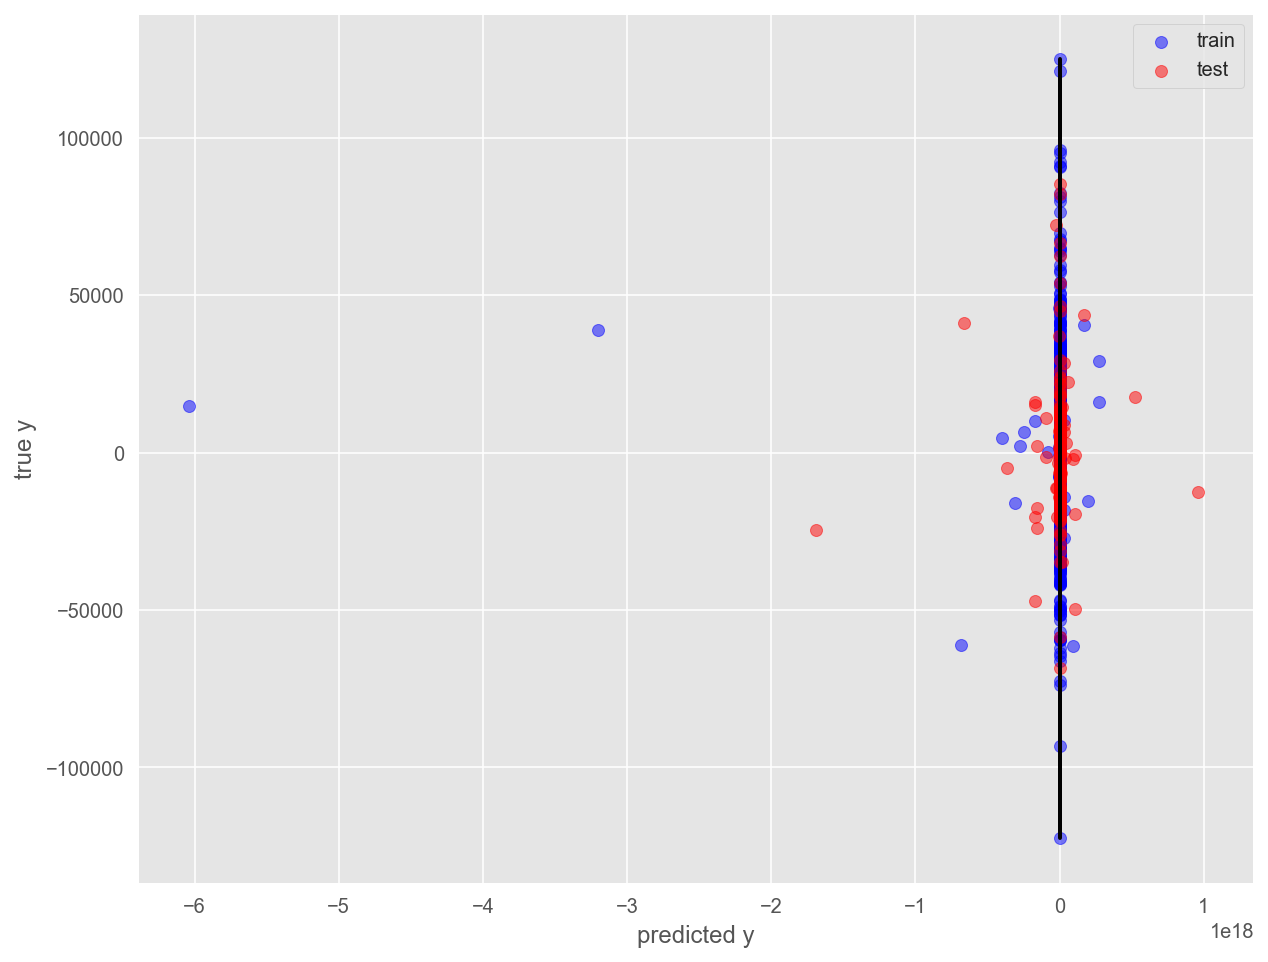

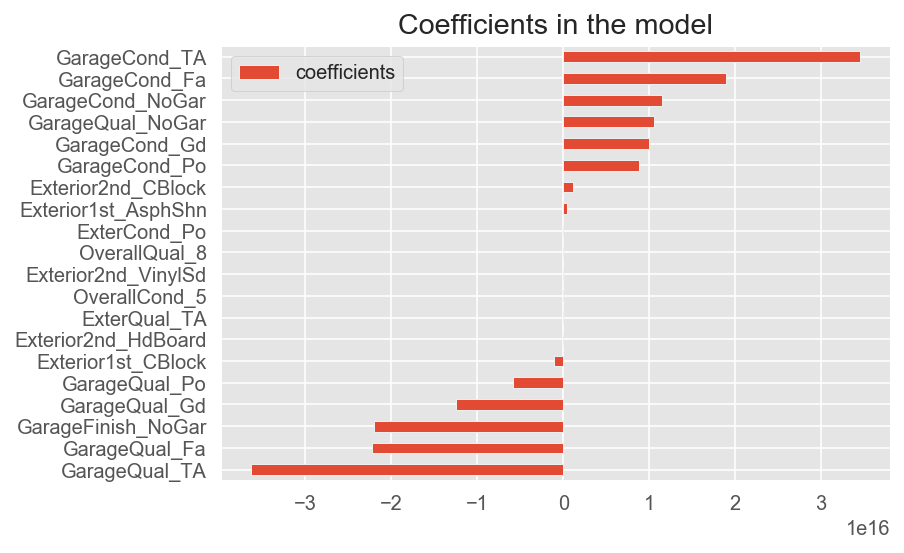

In [108]:
plt_predictions(model)
graph_coef(model)

## **~ Ridge**

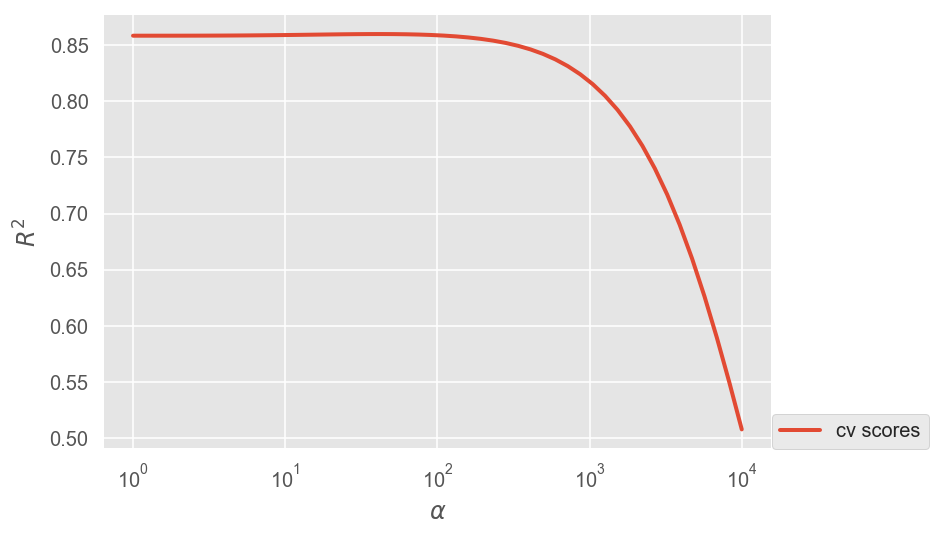

In [109]:
# Visualising alpha relationship to R2 to define a logspace

alpha_values = np.logspace(0, 4, 50)
scores = alpha_scores(Ridge, alpha_values=alpha_values)

plt.plot(alpha_values, [score[0] for score in scores], lw=2, label='cv scores')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$')
plt.legend(loc=[1, 0])
plt.show()

In [110]:
# create a RidgeCV model instance
model = RidgeCV(alphas=np.logspace(0,4,50), cv=KFold(n_splits=3,shuffle=False,random_state = 1))
# fit the model
model.fit(X_train, y_train)

# get the best alpha
print('Best alpha:', model.alpha_)

Best alpha: 281.1768697974228


In [111]:
model = Ridge(alpha = 281.17)
model_fitter(model, X_train, y_train, X_test, y_test)

(0.2224157489490838,
 0.1499943031243436,
 0.3610537964704491,
 0.2562033601111515)

(8.0, 10.0)

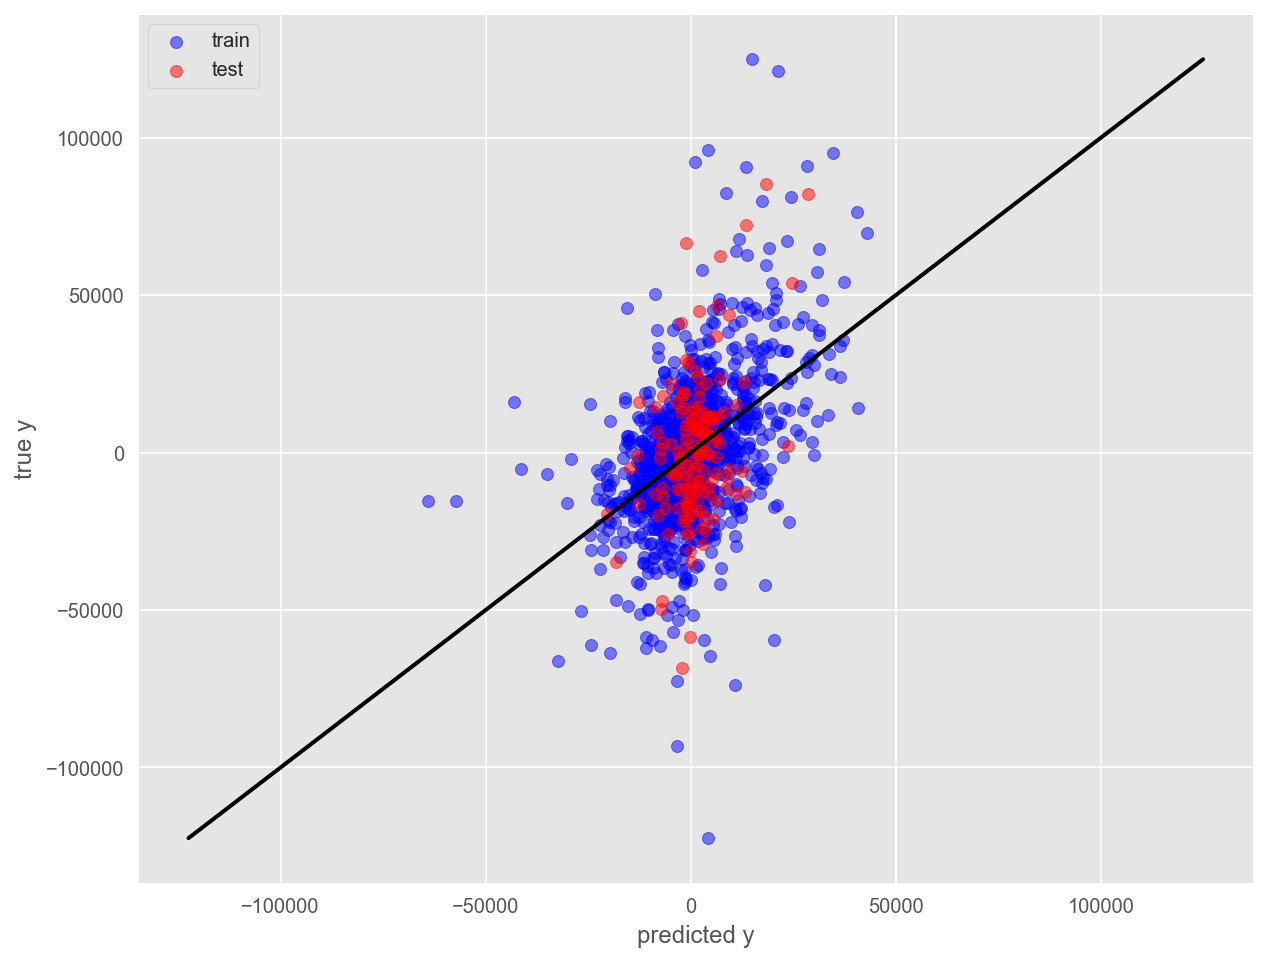

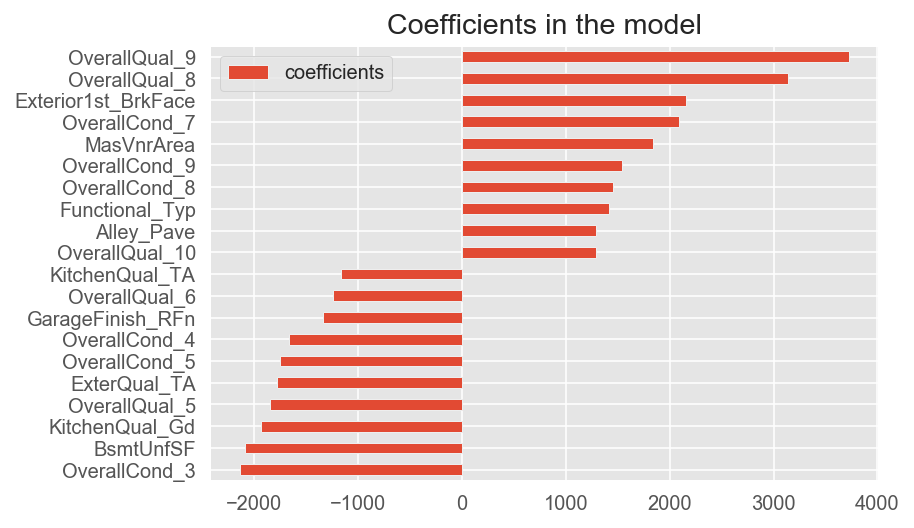

In [112]:
plt_predictions(model)
graph_coef(model)

## **~ Lasso**

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203111835470.4132, tolerance: 511041588.3237116
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116601230602.4693, tolerance: 323434631.10686517
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133810585683.8925, tolerance: 339047916.8094646
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11379650143

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156099400548.80914, tolerance: 511041588.3237116
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68344616874.689896, tolerance: 323434631.10686517
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112942333193.66144, tolerance: 339047916.8094646
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78635891

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84539171793.21973, tolerance: 511041588.3237116
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19475484130.82849, tolerance: 323434631.10686517
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60036411562.24043, tolerance: 339047916.8094646
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36533508964

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3870882152.4807434, tolerance: 323434631.10686517
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11684415785.607697, tolerance: 359479336.36584014
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606599748.9128141, tolerance: 46076971.04108572
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12770125

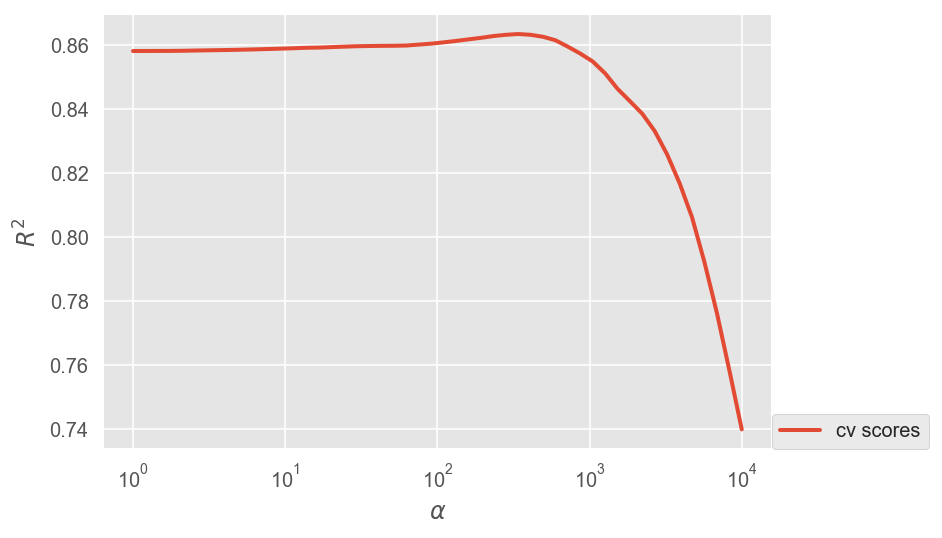

In [113]:
# Visualising alpha relationship to R2 to define a logspace

alpha_values = np.logspace(0, 4, 50)
scores = alpha_scores(Lasso, alpha_values=alpha_values)

plt.plot(alpha_values, [score[0] for score in scores], lw=2, label='cv scores')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$')
plt.legend(loc=[1, 0])
plt.show()

In [114]:
# create a RidgeCV model instance
model = LassoCV(alphas=np.logspace(0,4,50), cv=KFold(n_splits=3,shuffle=False,random_state = 1),max_iter = 10000)
# fit the model
model.fit(X_train, y_train)

# get the best alpha
print('Best alpha:', model.alpha_)

Best alpha: 494.1713361323833


In [115]:
model = Lasso(alpha=494)
model_fitter(model, X_train, y_train, X_test, y_test)

(0.23991554248078784,
 0.04629543826150565,
 0.3354916480129344,
 0.27664902469618535)

(8.0, 10.0)

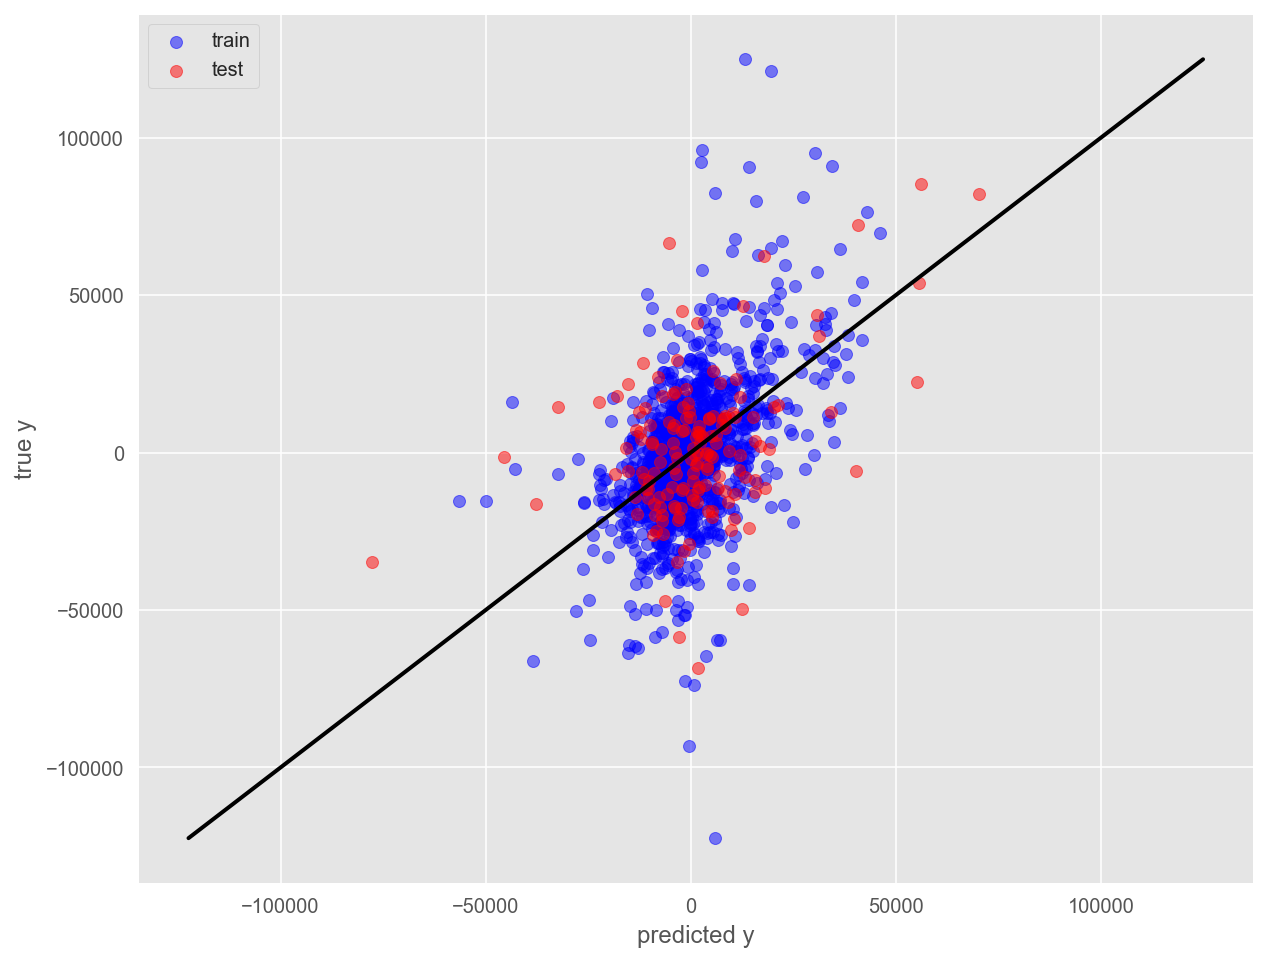

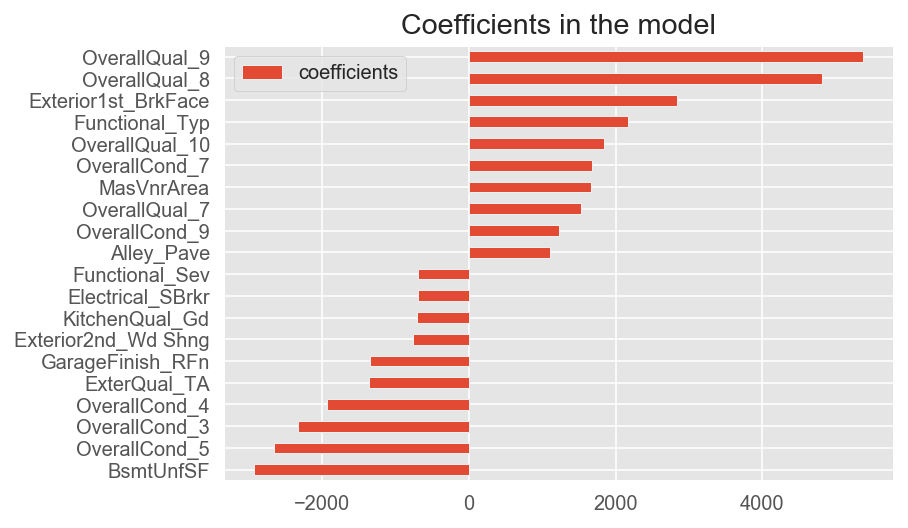

In [116]:
plt_predictions(model)
graph_coef(model)

## **~ ElasticNet**

In [117]:
model = ElasticNet(alpha=0.3, l1_ratio=0.8,max_iter = 10000)
model_fitter(model, X_train, y_train, X_test, y_test)

(0.19400750105934791,
 -0.3846495433372468,
 0.3809003875721376,
 0.255754471519839)

(8.0, 10.0)

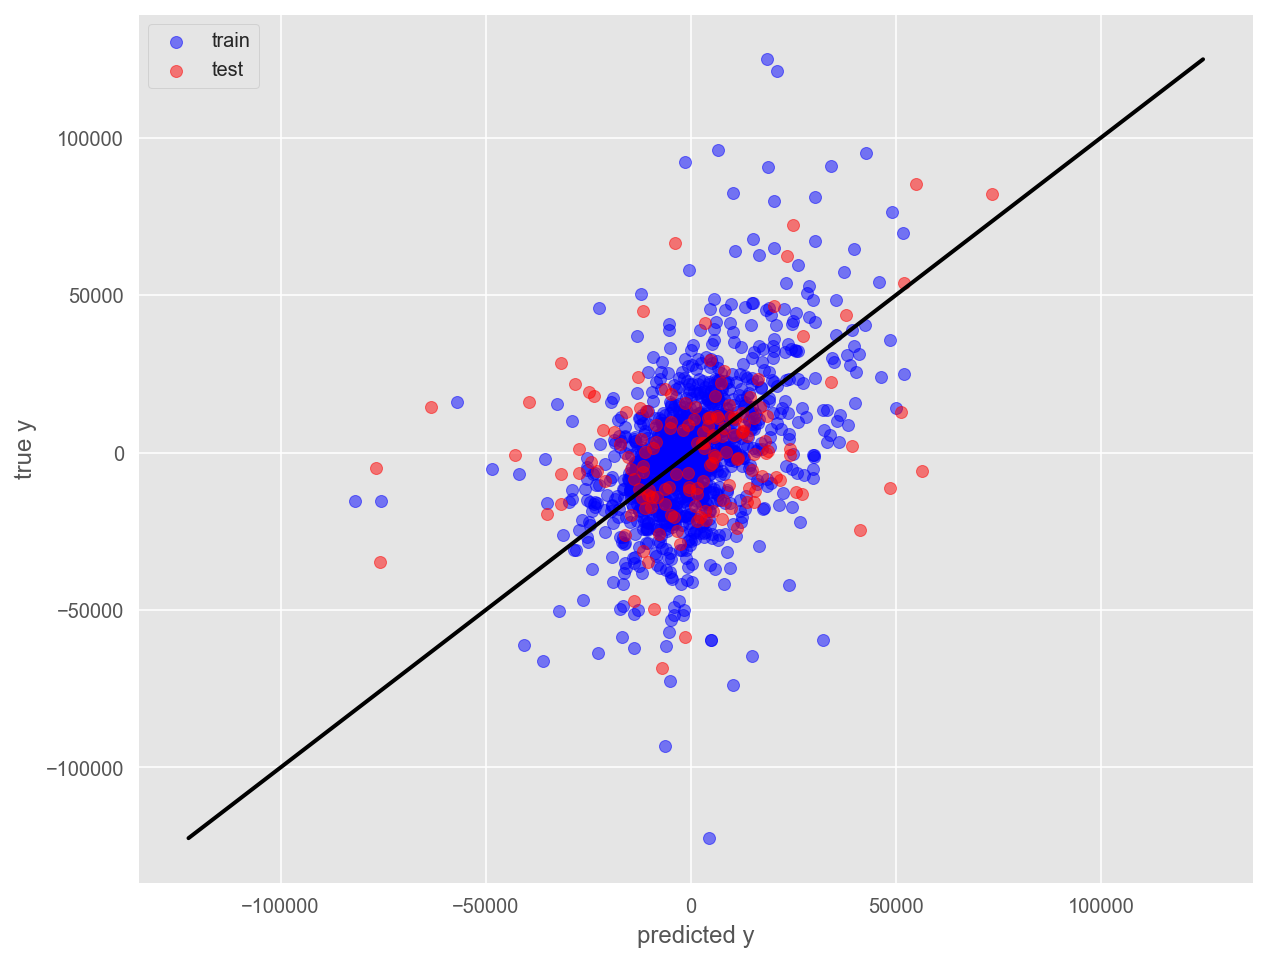

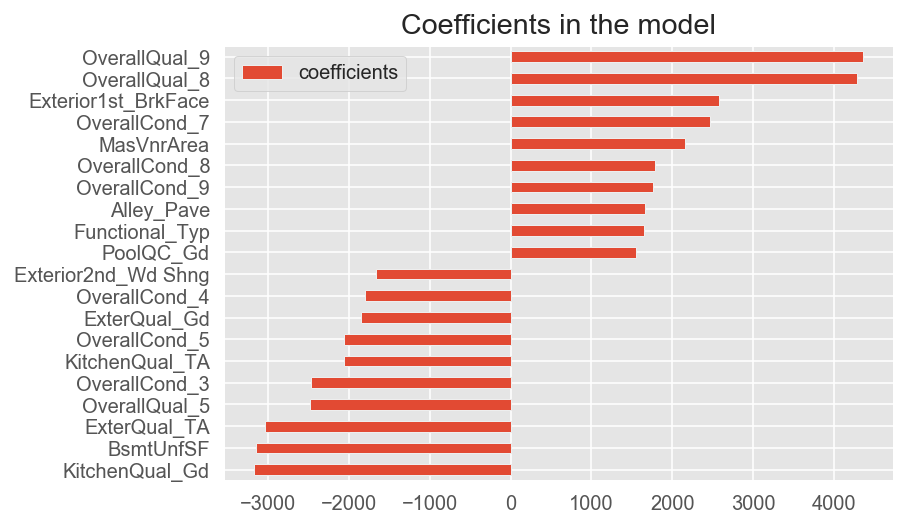

In [118]:
plt_predictions(model)
graph_coef(model)

### IV. Residuals

In [119]:
Xstd_res = scaler.transform(X)

In [120]:
# Getting predictions using the Ridge model 

model = Ridge(alpha = 281)
model.fit(Xstd_res,y)
res_yhat = model.predict(Xstd_res)

In [121]:
# Gettings Residuals 

z_res = y-res_yhat
z_res.head()

0     1506.21
1   -18979.95
2    11059.68
3   -45925.98
4   -45330.23
Name: residuals, dtype: float64

In [122]:
# looking at the standard deviation of residuals from model 1 & 2 
print(z.std())
print(z_res.std())

22333.348944071913
17855.81174757823


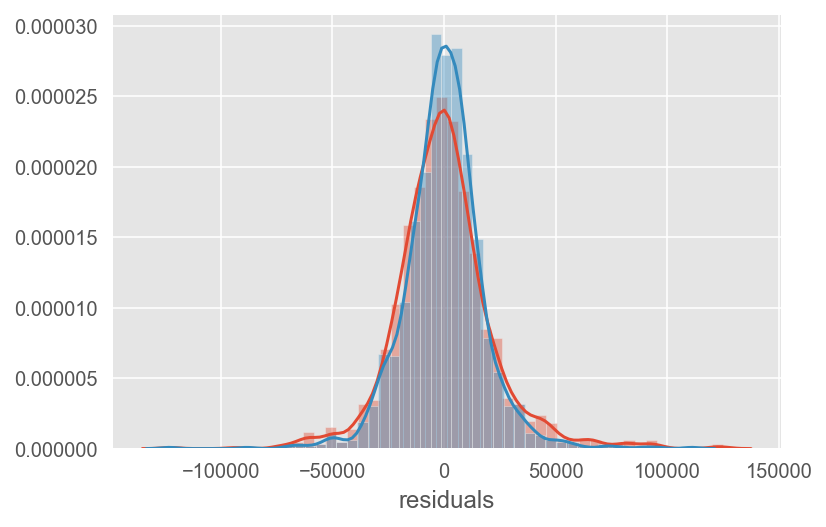

In [131]:
# Plotting both residuals 

ax = sns.distplot(z) #red
ax = sns.distplot(z_res) #blue


In [124]:
# Printing sum of both models residuals; closer to zero ?

print(z_res.sum())
print(z.sum())

-1.5425030142068863e-09
-1.664739102125168e-08


In [125]:
# Plotting predictions and target in a df

df = pd.DataFrame({'X': res_yhat, 'Y': y})
df.head()

,X,Y
0,3032.30,4538.51
1,5566.09,-13413.86
2,-2168.67,8891.02
3,-12579.61,-58505.59
4,8671.21,-36659.01


In [126]:
# MSE 1: Actual vs mean (baseline)

df['Mean_Yhat'] = df['Y'].mean()

In [127]:
baseline = df['Mean_Yhat']

In [132]:
df['Mean_Yhat_SE'] = np.square(df['Y'] - df['Mean_Yhat'])

print('Baseline MSE :', df['Mean_Yhat_SE'].mean())

Baseline MSE : 498405695.92833745


In [133]:
# MSE1: Actual vs Predicted

df['X_SE'] = np.square(df['Y'] - df['X'])
print('Predictions MSE :',df['X_SE'].mean())

Predictions MSE : 318591724.66482955


In [134]:
# Root mean squared error

print('Baseline RMSE :',df.Mean_Yhat_SE.mean()**0.5)
print('Predictions RMSE :', df.X_SE.mean()**0.5)

Baseline RMSE : 22325.001588540537
Predictions RMSE : 17849.137924976363


## Summary

Model 1 performed quite well and can be trusted to predict house price based on fixed features. However, there's place for improvement.

Even though model 2 performed poorly looking at the score, it performed better than the mean. The sum of residuals is close to zero and the standard deviation of residuals is smaller than model 1, implying a reduction of unexplained residuals.


Overall, the company should focus on buying properties in good neighborhoods with large living space but in poor conditions. Providing a kitchen of excellent quality and a finished basement will increase the value of the house. The exterior feature is also an important one. Using brick covering seems to have a significant positive effect on the value while wood shingles isn't popular. The quality of the material on exterior must be excellent. 

Having a paved alley access seeems to increase the value too and shouldn't be too costly to renovate. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: